# BNB strategy parameter search

# Set up

Set up Trading Strategy data client.


In [1]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Chain and validation test configuration

- Configure different chain parameters and allow fast switching between them
- This allows us to easily do backtest validation with data from different chains
- Each chain comes with different exchanges and different TVL depths we need to trade against,
  this cannot be automatically detected

In [2]:
from eth_defi.token import USDC_NATIVE_TOKEN
from eth_defi.token import USDT_NATIVE_TOKEN
from eth_defi.token import WRAPPED_NATIVE_TOKEN

from tradingstrategy.chain import ChainId
from tradingstrategy.lending import LendingProtocolType

CHAIN_ID = ChainId.binance


# We define our main trading universe,
# and then Ethereum mainnet as a validation set
match CHAIN_ID:

    case ChainId.base:

        EXCHANGES = ("uniswap-v2", "uniswap-v3",)

        SUPPORTING_PAIRS = [
            (ChainId.base, "uniswap-v2", "WETH", "USDC", 0.0030),  
            (ChainId.base, "uniswap-v3", "cbBTC", "WETH", 0.0030),    # Only trading since October
        ]

        EXAMINED_ASSETS = [
            "AIXBT", 
            "PEPE",
            "KEYCAT",
            "WETH",
            "cbBTC"
        ]

        VOL_PAIR = (CHAIN_ID, "uniswap-v2", "WETH", "USDC", 0.0030)

        #: Needed for USDC credit
        LENDING_RESERVES  = [
            (CHAIN_ID, LendingProtocolType.aave_v3, "USDC"),
        ]    

        PREFERRED_STABLECOIN = USDC_NATIVE_TOKEN[CHAIN_ID].lower()

        VAULTS = [

            # Harvest USDC Autopilot on Bas

            # Harvest USDC Autopilot on IPOR on Base
            # https://app.ipor.io/fusion/base/0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4
            (ChainId.base, "0x0d877Dc7C8Fa3aD980DfDb18B48eC9F8768359C4".lower()),

            # maxAPY USDC base
            # https://app.maxapy.io/vaults/super/usdc
            (ChainId.base, "0x7a63e8fc1d0a5e9be52f05817e8c49d9e2d6efae".lower()),

            # Morpho
            # Morpho Moonwell Flagship USDC Compounder
            (ChainId.base, "0xd5428b889621eee8060fc105aa0ab0fa2e344468".lower()),

            # Spark
            # Spark USDC Vault	
            (ChainId.base, "0x7bfa7c4f149e7415b73bdedfe609237e29cbf34a".lower()),
        ]

        MIN_TVL = 600_000
        MIN_VOLUME = 100_000
    
    case ChainId.ethereum:

        EXCHANGES = ("uniswap-v2", "uniswap-v3", "sushi")

        SUPPORTING_PAIRS = [
            (ChainId.ethereum, "uniswap-v2", "WETH", "USDC", 0.0030),  
            (ChainId.ethereum, "uniswap-v3", "WBTC", "USDC", 0.0030),    # Only trading since October
        ]

        EXAMINED_ASSETS = [
            "PEPE",
            "AAVE",
            "WETH",
            "WBTC",
        ]

        VOL_PAIR = (Parameters.chain_id, "uniswap-v3", "WBTC", "USDC", 0.0030)

        #: Needed for USDC credit
        LENDING_RESERVES  = [
            (Parameters.chain_id, LendingProtocolType.aave_v3, "USDC"),
        ]    

        PREFERRED_STABLECOIN = USDC_NATIVE_TOKEN[Parameters.chain_id.value].lower()


    case ChainId.binance:

        EXCHANGES = ("pancakeswap-v2", "pancakeswap-v3", "uniswap-v3")

        SUPPORTING_PAIRS = [
            (ChainId.binance, "pancakeswap-v2", "WBNB", "USDT", 0.0025),  
            (ChainId.binance, "pancakeswap-v2", "ETH", "WBNB", 0.0025),    # Only trading since October
        ]

        EXAMINED_ASSETS = [
            "WBNB",
            "FTC",
            "TRUNK",
            "CUMMIES",
        ]

        VOL_PAIR = (CHAIN_ID, "pancakeswap-v2", "WBNB", "USDT", 0.0025)

        LENDING_RESERVES = None

        PREFERRED_STABLECOIN = USDT_NATIVE_TOKEN[CHAIN_ID].lower()

        MIN_TVL = 400_000
        MIN_VOLUME = 25_000

        VAULTS = []

        TOKEN_RISK_ENABLED = True

    case ChainId.avalanche:
        SUPPORTING_PAIRS = [
            (ChainId.avalanche, "trader-joe", "WAVAX", "USDT.e", 0.0030),  
            (ChainId.avalanche, "trader-joe", "WETH.e", "WAVAX", 0.0030),    # Only trading since October
        ]

        EXAMINED_ASSETS = [
            "WAVAX",
            "JOE",
            "WETH.e",
        ]

        VOL_PAIR = (ChainId.avalanche, "trader-joe", "WAVAX", "USDT.e", 0.0030)

        PREFERRED_STABLECOIN = USDC_NATIVE_TOKEN[Parameters.chain_id.value].lower()

        LENDING_RESERVES = None    

    case _:
        raise NotImplementedError(f"Chain not supported: {CHAIN_ID}")

# Parameters

- Collection of parameters used in the calculations

In [3]:
import datetime

import pandas as pd

from skopt.space import Categorical

from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.default_routing_options import TradeRouting

from tradeexecutor.utils.jupyter_notebook_name import get_notebook_id



class Parameters:

    id = get_notebook_id(globals())

    # We trade 1h candle
    candle_time_bucket = TimeBucket.h1
    cycle_duration = CycleDuration.cycle_2h
    
    chain_id = CHAIN_ID
    exchanges = EXCHANGES
 
    #
    # Basket size, risk and balancing parametrs.
    #   
    min_asset_universe = 5  # How many assets we need in the asset universe to start running the index
    max_assets_in_portfolio = 12  # How many assets our basket can hold once
    allocation = 0.95  # Allocate all cash to volatile pairs
    # min_rebalance_trade_threshold_pct = 0.05  # % of portfolio composition must change before triggering rebalacne
    individual_rebalance_min_threshold_usd = 500.0  # Don't make buys less than this amount
    sell_rebalance_min_threshold = 100.0
    sell_threshold = 0.05  # Sell if asset is more than 5% of the portfolio
    per_position_cap_of_pool = 0.0050  # Never own more than % of the lit liquidity of the trading pool
    max_concentration = 0.15 # How large % can one asset be in a portfolio once
    min_portfolio_weight = 0.0050  # Close position / do not open if weight is less than 50 BPS

    #
    # ATH indicator parameters.
    #
    # How we determine local ATH.
    #
    ath_delay_bars = Categorical([12, 60, 144, 200, 360, 500])
    ath_window_bars = Categorical([
        10,
        25,
        50,
        100, 
        150, 
        360, 
        800,
        30*24,
        3*30*24,
        6*30*24
    ])
    ath_threshold = Categorical([0.50, 0.75, 0.9, 1.0, 1.1])
    ath_span = Categorical([2, 4, 6, 8, 12, 24, 30, 60, 100])

    #
    # Full ATH history filter parameters.
    #
    # Filter out bad tokens.
    #
    # If we are below 80% of all-time historical peak, never touch the token.
    #
    min_from_full_history_ath = Categorical([0.00, 0.15, 0.3, 0.75])

    #
    # Volatility binning filter
    # vol_bin_filter = None disabled
    #
    vol_bin_filter = None
    vol_bin_filter_lookback = 180
    daily_atr_length = 20
    vol_bin_level_1_threshold = 0.25

    #
    # Basket inclusion criteria.
    #
    # For the length of trailing sharpe used in inclusion criteria
    rolling_volume_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    rolling_volatility_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    tvl_ewm_span = 7 * 24  # Smooth TVL inclusin criteria
    min_volume = MIN_VOLUME   # USD
    min_tvl_prefilter = MIN_TVL  # USD - to reduce number of trading pairs for backtest-purposes only
    min_tvl = MIN_TVL     # USD - set to same as above if you want to avoid any survivorship bias
    min_token_sniffer_score = 20  # 20 = AAVE


    #
    # Yield on cash
    #
    use_managed_yield = False
    yield_flow_dust_threshold = 5.0  # Min deposit USD to Aave
    directional_trade_yield_buffer_pct = 0.01  # For credit flow, assume we might get this less cash released from sells


    #     
    #
    # Backtesting only
    # Limiting factor: Aave v3 on Base starts at the end of DEC 2023
    #
    backtest_start = datetime.datetime(2024, 3, 1)
    backtest_end = datetime.datetime(2025, 7, 15)
    initial_cash = 100_000

    #
    # Live only
    #
    routing = TradeRouting.default
    required_history_period = datetime.timedelta(days=30*12*3)
    slippage_tolerance = 0.0060  # 0.6% 
    assummed_liquidity_when_data_missings = 10_000
    

parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation


from tradeexecutor.strategy.parameters import display_parameters
display_parameters(parameters)

Value  \
Name                                                                                        
allocation                                                                           0.95   
assummed_liquidity_when_data_missings                                               10000   
ath_delay_bars                          Categorical(categories=(12, 60, 144, 200, 360,...   
ath_span                                Categorical(categories=(2, 4, 6, ..., 30, 60, ...   
ath_threshold                           Categorical(categories=(0.5, 0.75, 0.9, 1.0, 1...   
ath_window_bars                         Categorical(categories=(10, 25, 50, ..., 720, ...   
backtest_end                                                          2025-07-15 00:00:00   
backtest_start                                                        2024-03-01 00:00:00   
candle_time_bucket                                                          TimeBucket.h1   
chain_id                                                                               56   
cycle_duration                                                     CycleDuration.cycle_2h   
daily_atr_length                                                                       20   
directional_trade_yield_buffer_pct                                                   0.01   
exchanges                                    (pancakeswap-v2, pancakeswap-v3, uniswap-v3)   
id                                                             10-bnb-ath-optimise-sharpe   
individual_rebalance_min_threshold_usd                                              500.0   
initial_cash                                                                       100000   
max_assets_in_portfolio                                                                12   
max_concentration                                                                    0.15   
min_asset_universe                                                                      5   
min_from_full_history_ath               Categorical(categories=(0.0, 0.15, 0.3, 0.75),...   
min_portfolio_weight                                                                0.005   
min_token_sniffer_score                                                                20   
min_tvl                                                                            400000   
min_tvl_prefilter                                                                  400000   
min_volume                                                                          25000   
per_position_cap_of_pool                                                            0.005   
required_history_period                                                1080 days, 0:00:00   
rolling_volatility_bars                                                               168   
rolling_volume_bars                                                                   168   
routing                                                              TradeRouting.default   
sell_rebalance_min_threshold                                                        100.0   
sell_threshold                                                                       0.05   
slippage_tolerance                                                                  0.006   
tvl_ewm_span                                                                          168   
use_managed_yield                                                                   False   
vol_bin_filter                                                                       None   
vol_bin_filter_lookback                                                               180   
vol_bin_level_1_threshold                                                            0.25   
yield_flow_dust_threshold                                                             5.0   
grid_search                                                                         False   

                                                 Type  
Name                        

# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [4]:
import os

from pathlib import Path

from tradingstrategy.client import Client
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.client import Client
from tradingstrategy.client import Client

from tradingstrategy.utils.token_filter import add_base_quote_address_columns
from tradingstrategy.utils.token_filter import filter_for_exchange_slugs
from tradingstrategy.utils.token_filter import filter_pairs_default
from tradingstrategy.utils.token_extra_data import load_token_metadata
from tradingstrategy.utils.token_filter import filter_by_token_sniffer_score
from tradingstrategy.utils.token_filter import deduplicate_pairs_by_volume


from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.analysis.pair import display_strategy_universe

from tradingstrategy.utils.token_extra_data import load_token_metadata
from tradingstrategy.utils.token_filter import filter_by_token_sniffer_score


from eth_defi.token_analysis.tokenrisk import CachedTokenRisk
from tqdm_loggable.auto import tqdm


from dotenv import load_dotenv
load_dotenv(override=True)  # Loads variables from .env file



def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - Load Trading Strategy full pairs dataset

    - Load built-in Coingecko top 1000 dataset

    - Get all DEX tokens for a certain Coigecko category

    - Load OHCLV data for these pairs

    - Load also BTC and ETH price data to be used as a benchmark
    """

    if TOKEN_RISK_ENABLED:
        token_risk = CachedTokenRisk(
            api_key=os.environ["TOKEN_RISK_API_KEY"],
        )
    else:
        token_risk = None

    if execution_context.live_trading:
        # Live trading, send strategy universe formation details 
        # to logs
        debug_printer = logger.info
    else:    
        # Notebook node
        debug_printer = print

    chain_id = Parameters.chain_id

    debug_printer(f"Preparing trading universe on chain {chain_id.get_name()}")

    exchange_universe = client.fetch_exchange_universe()
    targeted_exchanges = [exchange_universe.get_by_chain_and_slug(chain_id, slug) for slug in Parameters.exchanges]
    
    # Pull out our benchmark pairs ids.
    # We need to construct pair universe object for the symbolic lookup.
    # TODO: PandasPairUniverse(buidl_index=True) - speed this up by skipping index building
    all_pairs_df = client.fetch_pair_universe().to_pandas()
    all_pairs_df = filter_for_exchange_slugs(all_pairs_df, Parameters.exchanges)
    debug_printer("Creating universe for benchmark pair extraction")
    pair_universe = PandasPairUniverse(
        all_pairs_df, 
        exchange_universe=exchange_universe,
        build_index=False,
    )
    debug_printer(f"Exchanges {Parameters.exchanges} have total {len(all_pairs_df):,} pairs on chain {Parameters.chain_id.get_name()}")

    # Get TVL data for prefilteirng
    if execution_context.live_trading:
        # For live trading, we take TVL data from ~around the start of the strategy until today
        tvl_time_bucket = TimeBucket.d1
        start = datetime.datetime(2024, 2, 1)
        end = tvl_time_bucket.floor(pd.Timestamp(datetime.datetime.utcnow() - tvl_time_bucket.to_timedelta()))
    else:
        start = Parameters.backtest_start
        end = Parameters.backtest_end

    #
    # Do exchange and TVL prefilter pass for the trading universe
    #
    min_tvl = Parameters.min_tvl_prefilter
    # logging.getLogger().setLevel(logging.INFO)
    liquidity_time_bucket = TimeBucket.d1
    tvl_df = client.fetch_tvl(
        mode="min_tvl_low",
        bucket=liquidity_time_bucket,
        start_time=start,
        end_time=end,
        exchange_ids=[exc.exchange_id for exc in targeted_exchanges],
        min_tvl=min_tvl,
    )
    # logging.getLogger().setLevel(logging.WARNING)
    debug_printer(f"Fetch TVL, we got {len(tvl_df['pair_id'].unique())} pairs with TVL data for min TVL criteria {min_tvl}")

    tvl_filtered_pair_ids = tvl_df["pair_id"].unique()
    benchmark_pair_ids = [pair_universe.get_pair_by_human_description(desc).pair_id for desc in SUPPORTING_PAIRS]
    needed_pair_ids = set(benchmark_pair_ids) | set(tvl_filtered_pair_ids)
    pairs_df = all_pairs_df[all_pairs_df["pair_id"].isin(needed_pair_ids)]
    debug_printer(f"After TVL prefilter to {Parameters.min_tvl_prefilter:,} in {Parameters.backtest_start} - {Parameters.backtest_end}, we have {len(pairs_df)} trading pairs")
    pairs_df = add_base_quote_address_columns(pairs_df)

    # Never deduplicate supporting pars
    supporting_pairs_df = pairs_df[pairs_df["pair_id"].isin(benchmark_pair_ids)]

    allowed_quotes = {
        PREFERRED_STABLECOIN,
        WRAPPED_NATIVE_TOKEN[chain_id.value].lower(),
    }
    filtered_pairs_df = filter_pairs_default(
        pairs_df,
        good_quote_token_addresses=allowed_quotes,
        verbose_print=print,
    )

    # Deduplicate trading pairs - Choose the best pair with the best volume
    deduplicated_df = deduplicate_pairs_by_volume(filtered_pairs_df)

    # Get our reference pairs back to the dataset
    pairs_df = pd.concat([deduplicated_df, supporting_pairs_df]).drop_duplicates(subset='pair_id', keep='first')
    debug_printer(f"After deduplication we have {len(pairs_df)} pairs")

    # Add benchmark pairs back to the dataset
    pairs_df = pd.concat([pairs_df, supporting_pairs_df]).drop_duplicates(subset='pair_id', keep='first')

    # Load metadata
    debug_printer("Loading metadata")
    # logging.getLogger().setLevel(logging.INFO)
    pairs_df = load_token_metadata(pairs_df, client, printer=debug_printer)
    # logging.getLogger().setLevel(logging.WARNING)

    # Scam filter using TokenSniffer
    risk_filtered_pairs_df = filter_by_token_sniffer_score(
        pairs_df,
        risk_score=Parameters.min_token_sniffer_score,
        printer=debug_printer,
        max_buy_tax=0.031,
        max_sell_tax=0.031,
    )

    # Check if we accidentally get rid of benchmark pairs we need for the strategy
    difference = set(benchmark_pair_ids).difference(set(risk_filtered_pairs_df["pair_id"]))
    if difference:
        first_dropped_id = next(iter(difference))
        first_dropped_data = pairs_df.loc[pairs_df.pair_id == first_dropped_id]
        assert len(first_dropped_data) == 1, f"Got {len(first_dropped_data)} entries: {first_dropped_data}"
        raise AssertionError(f"Benchmark trading pair dropped in filter_by_token_sniffer_score() check: {first_dropped_data.iloc[0]}")
    pairs_df = risk_filtered_pairs_df.sort_values("volume", ascending=False)
    debug_printer(f"After TokenSniffer risk filter we have {len(pairs_df)} pairs")

    # Remove extra pairs from the TVL data,
    # so we do not drag extra data and memory usage to the trading universe and liquidity candles
    tvl_pair_count_no_filtering = tvl_df["pair_id"].nunique()
    tvl_df = tvl_df[tvl_df["pair_id"].isin(pairs_df["pair_id"])]
    tvl_filtering_count = tvl_df["pair_id"].nunique()
    debug_printer(f"TVL data before risk filtering had {tvl_pair_count_no_filtering} pairs, after filtering we have {tvl_filtering_count} pairs")

    uni_v2 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v2"]
    uni_v3 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v3"]
    other_dex = pairs_df.loc[~((pairs_df["exchange_slug"] != "uniswap-v3") | (pairs_df["exchange_slug"] != "uniswap-v2"))]
    debug_printer(f"Pairs on Uniswap v2: {len(uni_v2)}, Uniswap v3: {len(uni_v3)}, other DEX: {len(other_dex)}")

    if execution_context.live_trading:
        # Bundled vault price data is only used for backtesting
        vault_bundled_price_data = None
    else:
        if VAULTS:
            vault_bundled_price_data=Path.home() / ".tradingstrategy" / "vaults" / "cleaned-vault-prices-1h.parquet"
        else:
            vault_bundled_price_data = None

    dataset = load_partial_data(
        client=client,
        time_bucket=Parameters.candle_time_bucket,
        pairs=pairs_df,
        execution_context=execution_context,
        universe_options=universe_options,
        liquidity_time_bucket=liquidity_time_bucket,
        preloaded_tvl_df=tvl_df,
        lending_reserves=LENDING_RESERVES,    
        vaults=VAULTS,
        vault_bundled_price_data=vault_bundled_price_data,
    )

    reserve_asset = PREFERRED_STABLECOIN
    
    debug_printer("Creating trading universe")
    strategy_universe = TradingStrategyUniverse.create_from_dataset(
        dataset,
        reserve_asset=reserve_asset,
        forward_fill=True,  # We got very gappy data from low liquid DEX coins
        forward_fill_until=timestamp,
    )

    # Tag benchmark/routing pairs tokens so they can be separated from the rest of the tokens
    # for the index construction.
    strategy_universe.warm_up_data()
    for pair_id in benchmark_pair_ids:
        pair = strategy_universe.get_pair_by_id(pair_id)
        pair.other_data["benchmark"] = False

    # Add Token Risk preliminary support
    if token_risk:    
        pairs = list(strategy_universe.iterate_pairs())
        removes = set()
        for pair in tqdm(pairs, desc="Loading Token Risk data"):
            pair.other_data["token_risk_data"] = token_risk.fetch_token_info(chain_id.value, pair.base.address) 

            risks = pair.get_token_risk_flags()
            if "risk_external_call_in_transfer" in risks:
                pair.set_tradeable(False)
                removes.add(pair)

        debug_printer(f"Token Risk data removing {len(removes)} pairs")

    debug_printer(f"Total {strategy_universe.get_pair_count()}")

    return strategy_universe


strategy_universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)

print("Universe creation done")

display_strategy_universe(
    strategy_universe, 
    sort_key="tvl",
    sort_numeric=True,
    sort_ascending=False,
    limit=10,
)


Preparing trading universe on chain BNB Smart Chain
Creating universe for benchmark pair extraction
Exchanges ('pancakeswap-v2', 'pancakeswap-v3', 'uniswap-v3') have total 195,762 pairs on chain BNB Smart Chain
Fetch TVL, we got 1156 pairs with TVL data for min TVL criteria 400000
After TVL prefilter to 400,000 in 2024-03-01 00:00:00 - 2025-07-15 00:00:00, we have 1156 trading pairs
Pairs in the input dataset 1156
Pairs having a good fee 1156
Pairs that are not stable-stable 1145
Pairs that are not derivative tokens 1144
Pairs that are not rebase tokens 1144
Pairs with good quote token 1101
Pairs with clean ASCII token name 1097
After deduplication we have 915 pairs
Loading metadata
Loading metadata for 914 base tokens in 915 trading pairs
Got data back for 914 tokens
TokenSniffer has 0 error entries
filter_by_token_sniffer_score(): total 915, missing metadata 0, missing TokenSniffer data 0, TokenSniffer error'ed: 0
Filtered by TokenSniffer risk score: 20, before: 915, after NA: 915, a

/Users/moo/code/trade-executor/deps/trading-strategy/tradingstrategy/utils/wrangle.py:250: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Loading Token Risk data:   0%|          | 0/409 [00:00<?, ?it/s]

Token Risk data removing 109 pairs
Total 409
Universe creation done
Results limited to first 10 entries


base quote        exchange    type  fee %        price  \
id                                                                    
1364813      WBNB  USDT  pancakeswap-v2  traded   0.25       688.72   
2091931      FIST  USDT  pancakeswap-v2  traded   0.25         0.44   
4638959   wkeyDAO  USDT  pancakeswap-v2  traded   0.25        27.73   
2159496     FLOKI  WBNB  pancakeswap-v2  traded   0.25         0.00   
1484344  BabyDoge  WBNB  pancakeswap-v2  traded   0.25  <not avail>   
6615421      Cake  USDT      uniswap-v3  traded   0.30         2.37   
4642940       LAF  USDT  pancakeswap-v2  traded   0.25         7.98   
4308732       CAT  WBNB  pancakeswap-v2  traded   0.25         0.00   
1688868      HERO  WBNB  pancakeswap-v2  traded   0.25         0.00   
6634977       ICC  USDT  pancakeswap-v2  traded   0.25       265.70   

            last_price_at       first_price_at       volume         tvl  \
id                                                                        
1364813  38 days 10:00:00  2024-03-01 00:00:00    338867.19  13,887,336   
2091931  38 days 10:00:00  2024-03-01 01:00:00     20855.04  11,491,858   
4638959  38 days 10:00:00  2024-11-07 14:00:00    186084.31  10,875,872   
2159496  38 days 10:00:00  2024-03-01 00:00:00     14255.26   8,492,876   
1484344                 -                    -  <not avail>   8,042,106   
6615421  38 days 10:00:00  2024-03-01 00:00:00     53814.59   7,284,071   
4642940  38 days 10:00:00  2024-11-10 15:00:00     15956.99   7,008,518   
4308732  38 days 10:00:00  2024-08-22 15:00:00      4522.76   5,053,518   
1688868  38 days 15:00:00  2024-03-01 00:00:00         0.00   5,007,020   
6634977  39 days 02:00:00  2025-04-26 01:00:00         0.00   4,608,515   

         tvl_at          tax  
id                            
1364813 38 days        - / -  
2091931 38 days        - / -  
4638959 38 days        - / -  
2159496 38 days  0.3% / 0.3%  
1484344 38 days        - / -  
6615421 38 days  0.0% / 0.0%  
4642940 38 days  3.0% / 3.0%  
4308732 38 days        - / -  
1688868 38 days        - / -  
6634977 38 days        - / -

### Asset to trading pair map

- Build a helper map
- Because we are operating on trading pairs, not on tokens, which are the base asset of a trading pair, we set up 
  this map to easily look up the selected trading pair by its symbol

In [5]:
from tradingstrategy.types import TokenSymbol
from tradeexecutor.state.identifier import TradingPairIdentifier

# Create base token symbol to pair map to help later
# Token
token_map: dict[TokenSymbol, TradingPairIdentifier] = {p.base.token_symbol: p for p in strategy_universe.iterate_pairs()}

# print(f"Pair count is {strategy_universe.get_pair_count()}")
# for symbol, pair in token_map.items():
#    print(f"{symbol} - #{pair.internal_id}")

# Tokens part of benchmark data, but not the strategy
benchmark_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is True]
category_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is not True]

print(f"Token map is {len(token_map)} assets")
print("Category trading pairs", len(category_pair_ids))
print("Benchmark trading pairs", len(benchmark_pair_ids))

Token map is 407 assets
Category trading pairs 409
Benchmark trading pairs 0


# Indicators

- Precalculate indicators used by the strategy

In [6]:
import pandas as pd
from IPython.display import HTML
import pandas_ta

from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSource
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.state.types import USDollarAmount
from tradeexecutor.strategy.pandas_trader.indicator_decorator import IndicatorRegistry
from tradeexecutor.analysis.indicator import display_indicators
from tradingstrategy.utils.groupeduniverse import resample_candles


indicators = IndicatorRegistry()

empty_series = pd.Series([], index=pd.DatetimeIndex([]))


@indicators.define()
def local_ath(
    close: pd.Series, 
    ath_delay_bars: int,
    ath_window_bars: int,
) -> pd.Series:
    """All time high indicator.

    - Calculate % we are above all time high

    :param ath_window_bars:
        We look history for this many bars to find ATH

    :param ath_delay_bars: 
        We skip the this most recent entries for ATH.

        E.g. ATH in a previous bar is ignored.
    
    :return:
        %  we are above lagged all time high.

        Value 1.1 means we are 10% above of the previous ATH.
    """
    shifted = close.shift(ath_delay_bars)
    windowed = shifted.rolling(
        window=ath_window_bars, 
        min_periods=1,
    ).max()
    series = (close / windowed)
    return series



@indicators.define()
def full_history_ath(
    close: pd.Series, 
) -> pd.Series:
    """How much we are below / above full history ATH/

    - Full history length

    :param ath_window_bars:
        We look history for this many bars to find ATH

    :param ath_delay_bars: 
        We skip the this most recent entries for ATH.

        E.g. ATH in a previous bar is ignored.
    
    :return:
        %  we are above lagged all time high.

        Value 1.1 means we are 10% above of the previous ATH.
    """
    windowed = close.rolling(
        window=len(close), 
        min_periods=1,
    ).max()
    series = (close / windowed)
    return series



@indicators.define()
def volatility(close: pd.Series, rolling_volatility_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rolling_volatility_bars).std()
    return rolling_std


@indicators.define()
def rolling_cumulative_volume(volume: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling volume of the pair.
    
    - Used in inclusion criteria
    """
    rolling_volume = volume.rolling(window=rolling_volume_bars).sum()
    return rolling_volume


@indicators.define()
def rolling_liquidity_avg(close: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling liquidity average

    - This is either TVL or XY liquidity (one sided) depending on the trading pair DEX type
    
    - Used in inclusion criteria
    """
    rolling_liquidity_close = close.rolling(window=rolling_volume_bars).mean()
    return  rolling_liquidity_close

    
@indicators.define(dependencies=(rolling_cumulative_volume,), source=IndicatorSource.strategy_universe)
def volume_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate pair volume inclusion criteria.

    - Avoid including illiquid / broken pairs in the set: Pair is included when it has enough volume 

    TODO: Add liquidity check later

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """

    series = dependency_resolver.get_indicator_data_pairs_combined(
        rolling_cumulative_volume,
        parameters={"rolling_volume_bars": rolling_volume_bars},
    )

    # Get mask for days when the rolling volume meets out criteria
    mask = series >= min_volume
    mask_true_values_only = mask[mask == True]

    # Turn to a series of lists
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series



@indicators.define(source=IndicatorSource.tvl)
def tvl(
    close: pd.Series,
    execution_context: ExecutionContext,
    timestamp: pd.Timestamp,
) -> pd.Series:
    """Get TVL series for a pair.

    - Because TVL data is 1d and we use 1h everywhere else, we need to forward fill

    - Use previous hourly close as the value
    """
    if execution_context.live_trading:
        # TVL is daily data.
        # We need to forward fill until the current hour.
        # Use our special ff function.        
        assert isinstance(timestamp, pd.Timestamp), f"Live trading needs forward-fill end time, we got {timestamp}"
        from tradingstrategy.utils.forward_fill import forward_fill
        df = pd.DataFrame({"close": close})
        df_ff = forward_fill(
            df,
            Parameters.candle_time_bucket.to_frequency(),
            columns=("close",),
            forward_fill_until=timestamp,
        )
        series = df_ff["close"]
        return series
    else:
        return close.resample("1h").ffill()


@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_per_pair)
def tvl_ewm(
    pair: TradingPairIdentifier,
    tvl_ewm_span: float,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Get smoothed TVL series for a pair.

    - Interpretation: If you set span=5, for example, the ewm function will compute an exponential moving average where the weight of the most recent observation is about 33.3% (since α=2/(5+1)≈0.333) and this weight decreases exponentially for older observations.

    - We forward fill gaps, so there is no missing data in decide_trades()    

    - Currently unused in the strategy itself
    """
    tvl_ff = dependency_resolver.get_indicator_data(
        tvl,
        pair=pair,
    )    
    return tvl_ff.ewm(span=tvl_ewm_span).mean()


@indicators.define(dependencies=(tvl_ewm, tvl), source=IndicatorSource.dependencies_only_universe)
def tvl_inclusion_criteria(   
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """The pair must have min XX,XXX USD one-sided TVL to be included.

    - If the Uniswap pool does not have enough ETH or USDC deposited, skip the pair as a scam

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(tvl)
    mask = series >= min_tvl
    # Turn to a series of lists
    mask_true_values_only = mask[mask == True]
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series



@indicators.define(
    source=IndicatorSource.strategy_universe
)
def trading_availability_criteria(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Is pair tradeable at each hour.

    - The pair has a price candle at that
    - Mitigates very corner case issues that TVL/liquidity data is per-day whileas price data is natively per 1h
      and the strategy inclusion criteria may include pair too early hour based on TVL only,
      leading to a failed attempt to rebalance in a backtest
    - Only relevant for backtesting issues if we make an unlucky trade on the starting date
      of trading pair listing

    :return:
        Series with with index (timestamp) and values (list of pair ids trading at that hour)
    """
    # Trading pair availability is defined if there is a open candle in the index for it.
    # Because candle data is forward filled, we should not have any gaps in the index.
    candle_series = strategy_universe.data_universe.candles.df["open"]
    pairs_per_timestamp = candle_series.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return pairs_per_timestamp


@indicators.define(
    dependencies=[
        volume_inclusion_criteria,
        tvl_inclusion_criteria,
        trading_availability_criteria
    ],
    source=IndicatorSource.strategy_universe
)
def inclusion_criteria(
    strategy_universe: TradingStrategyUniverse,
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Pairs meeting all of our inclusion criteria.

    - Give the tradeable pair set for each timestamp

    :return:
        Series where index is timestamp and each cell is a list of pair ids matching our inclusion criteria at that moment
    """

    # Filter out benchmark pairs like WETH in the tradeable pair set
    benchmark_pair_ids = set(strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS)

    volume_series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={
            "min_volume": min_volume,
            "rolling_volume_bars": rolling_volume_bars,
        },
    )

    tvl_series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={
            "min_tvl": min_tvl,
        },
    )

    trading_availability_series = dependency_resolver.get_indicator_data(trading_availability_criteria)

    #
    # Process all pair ids as a set and the final inclusion
    # criteria is union of all sub-criterias
    #

    df = pd.DataFrame({
        "tvl_pair_ids": tvl_series,
        "volume_pair_ids": volume_series,
        "trading_availability_pair_ids": trading_availability_series,
    })

    # https://stackoverflow.com/questions/33199193/how-to-fill-dataframe-nan-values-with-empty-list-in-pandas
    df = df.fillna("").apply(list)

    def _combine_criteria(row):
        final_set = set(row["volume_pair_ids"]) & \
                    set(row["tvl_pair_ids"]) & \
                    set(row["trading_availability_pair_ids"])
        return final_set - benchmark_pair_ids

    union_criteria = df.apply(_combine_criteria, axis=1)

    # Inclusion criteria data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=union_criteria.index.min(),
        end=union_criteria.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    reindexed = union_criteria.reindex(full_index, fill_value=[])
    return reindexed


@indicators.define(dependencies=(volume_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volume_included_pair_count(
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={"min_volume": min_volume, "rolling_volume_bars": rolling_volume_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(tvl_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def tvl_included_pair_count(
        min_tvl: USDollarAmount,
        dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={"min_tvl": min_tvl},
    )
    series = series.apply(len)

    # TVL data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=series.index.min(),
        end=series.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    # Reindex and fill NaN with zeros
    reindexed = series.reindex(full_index, fill_value=0)
    return reindexed


@indicators.define(dependencies=(inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def all_criteria_included_pair_count(
    min_volume: USDollarAmount,
    min_tvl: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Series where each timestamp is the list of pairs meeting all inclusion criteria.

    :return:
        Series with pair count for each timestamp
    """
    series = dependency_resolver.get_indicator_data(
        "inclusion_criteria",
        parameters={
            "min_volume": min_volume, 
            "min_tvl": min_tvl, 
            "rolling_volume_bars": rolling_volume_bars,
        },
    )
    return series.apply(len)


@indicators.define(source=IndicatorSource.strategy_universe)
def trading_pair_count(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Get number of pairs that trade at each timestamp.

    - Pair must have had at least one candle before the timestamp to be included

    - Exclude benchmarks pairs we do not trade

    :return:
        Series with pair count for each timestamp
    """

    benchmark_pair_ids = {strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS}

    # Get pair_id, timestamp -> timestamp, pair_id index
    series = strategy_universe.data_universe.candles.df["open"]    
    swap_index = series.index.swaplevel(0, 1)

    seen_pairs = set()
    seen_data = {}

    for timestamp, pair_id in swap_index:
        if pair_id in benchmark_pair_ids:
            continue
        seen_pairs.add(pair_id)
        seen_data [timestamp] = len(seen_pairs)

    series = pd.Series(seen_data.values(), index=list(seen_data.keys()))
    return series



@indicators.define(dependencies=(volatility,), source=IndicatorSource.strategy_universe)
def avg_volatility(
    strategy_universe,
    rolling_volatility_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate index avg volatility across all trading pairs.

    :return:
        Series with pair count for each timestamp
    """

    volatility = dependency_resolver.get_indicator_data_pairs_combined(
        "volatility",
        parameters={"rolling_volatility_bars": rolling_volatility_bars},
    )

    n_std = 3
    def remove_outliers_group(group):
        mean = group.mean()
        std = group.std()
        lower_bound = mean - n_std * std
        upper_bound = mean + n_std * std
        return group[(group >= lower_bound) & (group <= upper_bound)]
    
    cleaned = volatility.groupby(level='timestamp').apply(remove_outliers_group)
    
    # Group by timestamp, remove outliers within each group, then calculate mean
    cleaned_volatility = cleaned.groupby(level=0).mean()
    
    return cleaned_volatility



@indicators.define(source=IndicatorSource.ohlcv)
def daily_price(open, high, low, close, execution_context) -> pd.DataFrame:
    """Resample finer granularity price feed to daily for ADX filtering."""
    original_df = pd.DataFrame({
        "open": open,
        "high": high,
        "low": low,
        "close": close,
    })    
    daily_df = resample_candles(original_df, pd.Timedelta(days=1))

    if execution_context.live_trading:
        # TVL is daily data.
        # We need to forward fill until the current hour.
        # Use our special ff function.
        assert isinstance(timestamp, pd.Timestamp), f"Live trading needs forward-fill end time, we got {timestamp}"
        df = pd.DataFrame({"close": close})
        df_ff = forward_fill(
            df,
            Parameters.candle_time_bucket.to_frequency(),
            columns=("close",),
            forward_fill_until=timestamp,
        )
        series = df_ff["close"]
        return series


    return daily_df


@indicators.define(
    source=IndicatorSource.dependencies_only_per_pair,
    dependencies=[
        local_ath, 
        full_history_ath,  
    ]
)
def signal(
    ath_delay_bars: int,
    ath_window_bars: int,
    ath_threshold: float,
    ath_span: int,


    min_from_full_history_ath: float,
    
    # vol_bin_filter: set,
    # vol_bin_filter_lookback: int,
    # daily_atr_length: int,
    # vol_bin_level_1_threshold: float,
    candle_time_bucket: TimeBucket,

    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver    
) -> pd.Series:
    """Combine ATH signal with daily RSI filter.
    
    - We use daily RSI filter to get rid of crap pairs like FTC
    """


    ath = dependency_resolver.get_indicator_data(
        "local_ath",
        parameters={
            "ath_delay_bars": ath_delay_bars,
            "ath_window_bars": ath_window_bars,
        },
        pair=pair,
    )
    
    ath_core = ath.ewm(span=ath_span).mean() - ath_threshold
    signal_core = ath_core
    
    mask = pd.Series(True, signal_core.index)
    
    df = pd.DataFrame({
        "signal_core": signal_core,
        "mask": mask,
    })

    #if roc_length != 0:
    #      mask = mask & (df["roc"] >= roc_threshold)

    #if ema_length != 0:
    #      mask = mask & (df["close"] >= df["ema"])

    if min_from_full_history_ath != 0:
        full_history_ath = dependency_resolver.get_indicator_data(
            "full_history_ath",
            parameters={},
            pair=pair,
        )
        mask = mask & (full_history_ath >= min_from_full_history_ath)

    df['signal'] = 0.0  # Initialize the resulting signal with zeros
    df.loc[mask, 'signal'] = df.loc[mask, 'signal_core']  # Only allow signal to pass if it clears all of our masks
    return df["signal"]        


@indicators.define(dependencies=(signal,), source=IndicatorSource.dependencies_only_universe)
def avg_signal(
    ath_delay_bars: int,
    ath_window_bars: int,
    ath_threshold: float,
    ath_span: int,    
    min_from_full_history_ath: float,
    candle_time_bucket: TimeBucket,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate avg signal across all pairs

    - Useful to see the signal across all pairs and how the market moves overall
    - Use median with filtering

    :return:
        Series with pair count for each timestamp
    """

    signal = dependency_resolver.get_indicator_data_pairs_combined(
        "signal",
        parameters={
            "ath_window_bars": ath_window_bars,
            "ath_delay_bars": ath_delay_bars,
            "ath_threshold": ath_threshold,
            "ath_span": ath_span,
            "min_from_full_history_ath": min_from_full_history_ath,
            "candle_time_bucket": candle_time_bucket,
        },
    )

    n_std = 3
    def remove_outliers_group(group):
        mean = group.mean()
        std = group.std()
        lower_bound = mean - n_std * std
        upper_bound = mean + n_std * std
        return group[(group >= lower_bound) & (group <= upper_bound)]
    
    cleaned = signal.groupby(level='timestamp').apply(remove_outliers_group)
    
    # Group by timestamp, remove outliers within each group, then calculate mean
    cleaned_avg_signal = cleaned.groupby(level=0).median()
    
    return cleaned_avg_signal


display_indicators(indicators)


We have 19 indicators:


Order                      Source  \
Name                                                                  
daily_price                           1                       ohlcv   
full_history_ath                      1                 close_price   
local_ath                             1                 close_price   
rolling_cumulative_volume             1                       ohlcv   
rolling_liquidity_avg                 1                 close_price   
trading_availability_criteria         1           strategy_universe   
trading_pair_count                    1           strategy_universe   
tvl                                   1                         tvl   
volatility                            1                 close_price   
avg_volatility                        2           strategy_universe   
signal                                2  dependencies_only_per_pair   
tvl_ewm                               2  dependencies_only_per_pair   
volume_inclusion_criteria             2           strategy_universe   
avg_signal                            3  dependencies_only_universe   
tvl_inclusion_criteria                3  dependencies_only_universe   
volume_included_pair_count            3  dependencies_only_universe   
inclusion_criteria                    4           strategy_universe   
tvl_included_pair_count               4  dependencies_only_universe   
all_criteria_included_pair_count      5  dependencies_only_universe   

                                                                         Parameters  \
Name                                                                                  
daily_price                                                                           
full_history_ath                                                                      
local_ath                                        ath_delay_bars<br> ath_window_bars   
rolling_cumulative_volume                                       rolling_volume_bars   
rolling_liquidity_avg                                           rolling_volume_bars   
trading_availability_criteria                                                         
trading_pair_count                                                                    
tvl                                                                                   
volatility                                                  rolling_volatility_bars   
avg_volatility                                              rolling_volatility_bars   
signal                            ath_threshold<br> ath_delay_bars<br> candle_ti...   
tvl_ewm                                                                tvl_ewm_span   
volume_inclusion_criteria                        min_volume<br> rolling_volume_bars   
avg_signal                        ath_threshold<br> ath_delay_bars<br> candle_ti...   
tvl_inclusion_criteria                                                      min_tvl   
volume_included_pair_count                       min_volume<br> rolling_volume_bars   
inclusion_criteria                   min_tvl<br> min_volume<br> rolling_volume_bars   
tvl_included_pair_count                                                     min_tvl   
all_criteria_included_pair_count     min_tvl<br> min_volume<br> rolling_volume_bars   

                                                                       Dependencies  
Name                                                                                 
daily_price                                                                          
full_history_ath                                                                     
local_ath                                                                            
rolling_cumulative_volume                                                            
rolling_liquidity_avg                                                                
trading_availability_criteria                                                        
trading_pair_count        

# Backtest time range

- Choose the backtesting time range
- Start when we have enough assets (`Parameters.min_asset_universe`) in our asset universe to form the first basket

In [7]:
# Get the first date where the condition is True
backtest_start = pd.Timestamp("2024-04-01")
backtest_end = Parameters.backtest_end

print(f"Time range is {backtest_start} - {backtest_end}")

Time range is 2024-04-01 00:00:00 - 2025-07-15 00:00:00


# Strategy algorithm and backtest

- Run the backtest

In [8]:
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput, IndicatorDataNotFoundWithinDataTolerance
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.strategy.tvl_size_risk import USDTVLSizeRiskModel
from tradeexecutor.strategy.weighting import weight_by_1_slash_n, weight_passthrouh, weight_equal
from tradeexecutor.utils.dedent import dedent_any
from tradeexecutor.strategy.pandas_trader.yield_manager import YieldManager, YieldRuleset, YieldWeightingRule, YieldDecisionInput
from tradeexecutor.strategy.execution_context import ExecutionContext, ExecutionMode

def create_yield_rules(
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
) -> YieldRuleset:
    """Create yield rules for the strategy."""

    aave_usdc = strategy_universe.get_credit_supply_pair()
    ipor_usdc = strategy_universe.get_pair_by_smart_contract(VAULTS[0][1])
    maxapy_usdc = strategy_universe.get_pair_by_smart_contract(VAULTS[1][1])
    morpho_flagship = strategy_universe.get_pair_by_smart_contract(VAULTS[2][1])
    spark = strategy_universe.get_pair_by_smart_contract(VAULTS[3][1])

    # Check we have yield vault metadata loaded
    assert aave_usdc
    assert ipor_usdc
    assert maxapy_usdc
    assert morpho_flagship
    assert spark

    return YieldRuleset(
        position_allocation=parameters.allocation,
        buffer_pct=parameters.directional_trade_yield_buffer_pct,
        cash_change_tolerance_usd=parameters.yield_flow_dust_threshold,
        weights=[
            YieldWeightingRule(
                pair=maxapy_usdc, 
                max_concentration=0.75,
                max_pool_participation=0.05,
            ),
            YieldWeightingRule(
                pair=ipor_usdc, 
                max_concentration=0.75,
                max_pool_participation=0.05,    
            ),
            YieldWeightingRule(
                pair=morpho_flagship,   
                max_concentration=0.75,
                max_pool_participation=0.25,    
            ),

            YieldWeightingRule(
                pair=spark, 
                max_concentration=0.75,
                max_pool_participation=0.25,    
            ),

            YieldWeightingRule(pair=aave_usdc, max_concentration=1.0),
        ]
    )



def decide_trades(
    input: StrategyInput
) -> list[TradeExecution]:
    """For each strategy tick, generate the list of trades."""
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    portfolio = position_manager.get_current_portfolio()
    equity = portfolio.get_total_equity()
    
    # All gone, stop doing decisions
    if input.execution_context.mode == ExecutionMode.backtesting:
        if equity < parameters.initial_cash * 0.10:
            return []
        
    # Build signals for each pair
    alpha_model = AlphaModel(
        timestamp,
        close_position_weight_epsilon=parameters.min_portfolio_weight,  # 10 BPS is our min portfolio weight
    )

    vol_pair = strategy_universe.get_pair_by_human_description(VOL_PAIR)
    volume_included_pair_count = indicators.get_indicator_value(
        "volume_included_pair_count",
    )
    tvl_included_pair_count = indicators.get_indicator_value(
        "tvl_included_pair_count",
    )

    # Get pairs included in this rebalance cycle.
    # This includes pair that have been pre-cleared in inclusion_criteria()
    # with volume, volatility and TVL filters
    included_pairs = indicators.get_indicator_value(
        "inclusion_criteria",
        na_conversion=False,
    )
    if included_pairs is None:
        included_pairs = []

    # Set signal for each pair
    signal_count = 0
    for pair_id in included_pairs:
        pair = strategy_universe.get_pair_by_id(pair_id)

        if not state.is_good_pair(pair):
            # Tradeable flag set to False, etc.
            continue

        pair_signal = indicators.get_indicator_value("signal", pair=pair)
        if pair_signal is None:
            continue

        weight = pair_signal

        if weight < 0:
            continue

        alpha_model.set_signal(
            pair,
            weight,
        )

        # Diagnostics reporting
        signal_count += 1

    # Calculate how much dollar value we want each individual position to be on this strategy cycle,
    # based on our total available equity
    portfolio_target_value = equity * parameters.allocation


    # Select max_assets_in_portfolio assets in which we are going to invest
    # Calculate a weight for ecah asset in the portfolio using 1/N method based on the raw signal
    alpha_model.select_top_signals(count=parameters.max_assets_in_portfolio)
    alpha_model.assign_weights(method=weight_passthrouh)
    # alpha_model.assign_weights(method=weight_by_1_slash_n)

    #
    # Normalise weights and cap the positions
    #
    size_risk_model = USDTVLSizeRiskModel(
        pricing_model=input.pricing_model,
        per_position_cap=parameters.per_position_cap_of_pool,  # This is how much % by all pool TVL we can allocate for a position
        missing_tvl_placeholder_usd=0.0,  # Placeholder for missing TVL data until we get the data off the chain
    )

    alpha_model.normalise_weights(
        investable_equity=portfolio_target_value,
        size_risk_model=size_risk_model,
        max_weight=parameters.max_concentration,
    )

    # Load in old weight for each trading pair signal,
    # so we can calculate the adjustment trade size
    alpha_model.update_old_weights(
        state.portfolio,
        ignore_credit=True,
    )
    alpha_model.calculate_target_positions(position_manager)

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals (momentum)

    # rebalance_threshold_usd = portfolio_target_value * parameters.min_rebalance_trade_threshold_pct
    rebalance_threshold_usd = parameters.individual_rebalance_min_threshold_usd

    assert rebalance_threshold_usd > 0.1, "Safety check tripped - something like wrong with strat code"
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=rebalance_threshold_usd,  # Don't bother with trades under XXXX USD
        invidiual_rebalance_min_threshold=parameters.individual_rebalance_min_threshold_usd,
        sell_rebalance_min_threshold=parameters.sell_rebalance_min_threshold,
        execution_context=input.execution_context,
    )

    # Move cash in and out yield managed to cover spot positions
    if parameters.use_managed_yield:

        yield_manager = YieldManager(
            position_manager=position_manager,
            rules=create_yield_rules(parameters, strategy_universe),
        )

        yield_input = YieldDecisionInput(
            execution_mode=input.execution_context.mode,
            cycle=input.cycle,
            timestamp=timestamp,
            total_equity=state.portfolio.get_total_equity(),
            directional_trades=trades,
            size_risk_model=size_risk_model,
            pending_redemptions=position_manager.get_pending_redemptions(),
        )

        yield_result = yield_manager.calculate_yield_management(yield_input)
        trades += yield_result.trades

    else:
        yield_result = None

    # Add verbal report about decision made/not made,
    # so it is much easier to diagnose live trade execution.
    # This will be readable in Discord/Telegram logging.
    if input.is_visualisation_enabled():
        try:
            top_signal = next(iter(alpha_model.get_signals_sorted_by_weight()))
            if top_signal.normalised_weight == 0:
                top_signal = None
        except StopIteration:
            top_signal = None

        rebalance_volume = sum(t.get_value() for t in trades)

        report = dedent_any(f"""
        Cycle: #{input.cycle}
        Rebalanced: {'👍' if alpha_model.is_rebalance_triggered() else '👎'}
        Open/about to open positions: {len(state.portfolio.open_positions)} 
        Max position value change: {alpha_model.max_position_adjust_usd:,.2f} USD
        Rebalance threshold: {alpha_model.position_adjust_threshold_usd:,.2f} USD
        Trades decided: {len(trades)}
        Pairs total: {strategy_universe.data_universe.pairs.get_count()}
        Pairs meeting inclusion criteria: {len(included_pairs)}
        Pairs meeting volume inclusion criteria: {volume_included_pair_count}
        Pairs meeting TVL inclusion criteria: {tvl_included_pair_count}        
        Signals created: {signal_count}
        Total equity: {portfolio.get_total_equity():,.2f} USD
        Cash: {position_manager.get_current_cash():,.2f} USD
        Investable equity: {alpha_model.investable_equity:,.2f} USD
        Accepted investable equity: {alpha_model.accepted_investable_equity:,.2f} USD
        Allocated to signals: {alpha_model.get_allocated_value():,.2f} USD
        Discarted allocation because of lack of lit liquidity: {alpha_model.size_risk_discarded_value:,.2f} USD
        Yield flow: {yield_result and yield_result.trade_cash_diff or 0:,.2f} USD
        Yield trades: {yield_result and yield_result.trades or '-'}
        Rebalance volume: {rebalance_volume:,.2f} USD
        """)

        # Most volatility pair signal weight (normalised): {max_vol_signal.normalised_weight * 100 if max_vol_signal else '-'} % (got {max_vol_signal.position_size_risk.get_relative_capped_amount() * 100 if max_vol_signal else '-'} % of asked size)
        if top_signal:
            assert top_signal.position_size_risk
            report += dedent_any(f"""
            Top signal pair: {top_signal.pair.get_ticker()}
            Top signal value: {top_signal.signal}
            Top signal weight: {top_signal.raw_weight}
            Top signal weight (normalised): {top_signal.normalised_weight * 100:.2f} % (got {top_signal.position_size_risk.get_relative_capped_amount() * 100:.2f} % of asked size)
            """)

        for flag, count in alpha_model.get_flag_diagnostics_data().items():
            report += f"Signals with flag {flag.name}: {count}\n"

        state.visualisation.add_message(
            timestamp,
            report,
        )

        state.visualisation.set_discardable_data("alpha_model", alpha_model)

    return trades  # Return the list of trades we made in this cycle



# Optimiser

- Run optimiser

In [9]:
import logging
from tradeexecutor.backtest.optimiser import perform_optimisation
from tradeexecutor.backtest.optimiser import prepare_optimiser_parameters
from tradeexecutor.backtest.optimiser import MinTradeCountFilter
from tradeexecutor.backtest.optimiser_functions import optimise_sharpe, optimise_sortino, optimise_profit

# How many Gaussian Process iterations we do
iterations = 16

# What do we optimise for
# search_func = BalancedSharpeAndMaxDrawdownOptimisationFunction(sharpe_weight=0.75, max_drawdown_weight=0.25)
search_func = optimise_sharpe

optimiser_result = perform_optimisation(
    iterations=iterations,
    search_func=search_func,
    decide_trades=decide_trades,
    strategy_universe=strategy_universe,
    parameters=prepare_optimiser_parameters(Parameters),  # Handle scikit-optimise search space
    create_indicators=indicators.create_indicators,
    result_filter=MinTradeCountFilter(50),
    timeout=70*60,    
    batch_size=5,
    # We are searching wacky parameter combinations and
    # some of them lead to buggy strategies,
    # by setting ignore_wallet_errors we just zero out buggy
    # strategies instead of crashing with an exception
    ignore_wallet_errors=True,  
    # Uncomment for diagnostics
    # log_level=logging.INFO,
    # max_workers=1,
)

print(f"Optimise completed, optimiser searched {optimiser_result.get_combination_count()} combinations, with {optimiser_result.get_cached_count()} results read directly from cache. and {optimiser_result.get_filtered_count()} filtered results.")
print("Backtests failed with exception:", optimiser_result.get_failed_count())

Optimiser search result cache is /Users/moo/.cache/tradingstrategy/grid-search/10-bnb-ath-optimise-sharpe
Indicator cache is /Users/moo/.cache/indicators


Optimising 10-bnb-ath-optimise-sharpe, search space is 5 variables, using 10 CPUs:   0%|          | 0/16 [00:0…

Optimise completed, optimiser searched 80 combinations, with 80 results read directly from cache. and 0 filtered results.
Backtests failed with exception: 0


# Results

- Show the top results of all optimiser iterations in a single table

In [10]:
from tradeexecutor.analysis.optimiser import analyse_optimiser_result
from tradeexecutor.analysis.grid_search import render_grid_search_result_table


filtered = [r for r in optimiser_result.results if r.filtered]
print(f"Filtering out {len(filtered)} results")

# Optimiser already filtered for min_positions_threshold when doing the optimiser run
df = analyse_optimiser_result(
    optimiser_result,
    max_search_results=300,
    drop_duplicates=False,
)
print(f"Showing the best {len(df)} results")

render_grid_search_result_table(df)
 

Filtering out 0 results
Showing the best 80 results


# Parameter analysis

## Decision tree visualisation

Analysing CAGR for parameters: ['ath_delay_bars', 'ath_span', 'ath_threshold', 'ath_window_bars', 'min_from_full_history_ath']


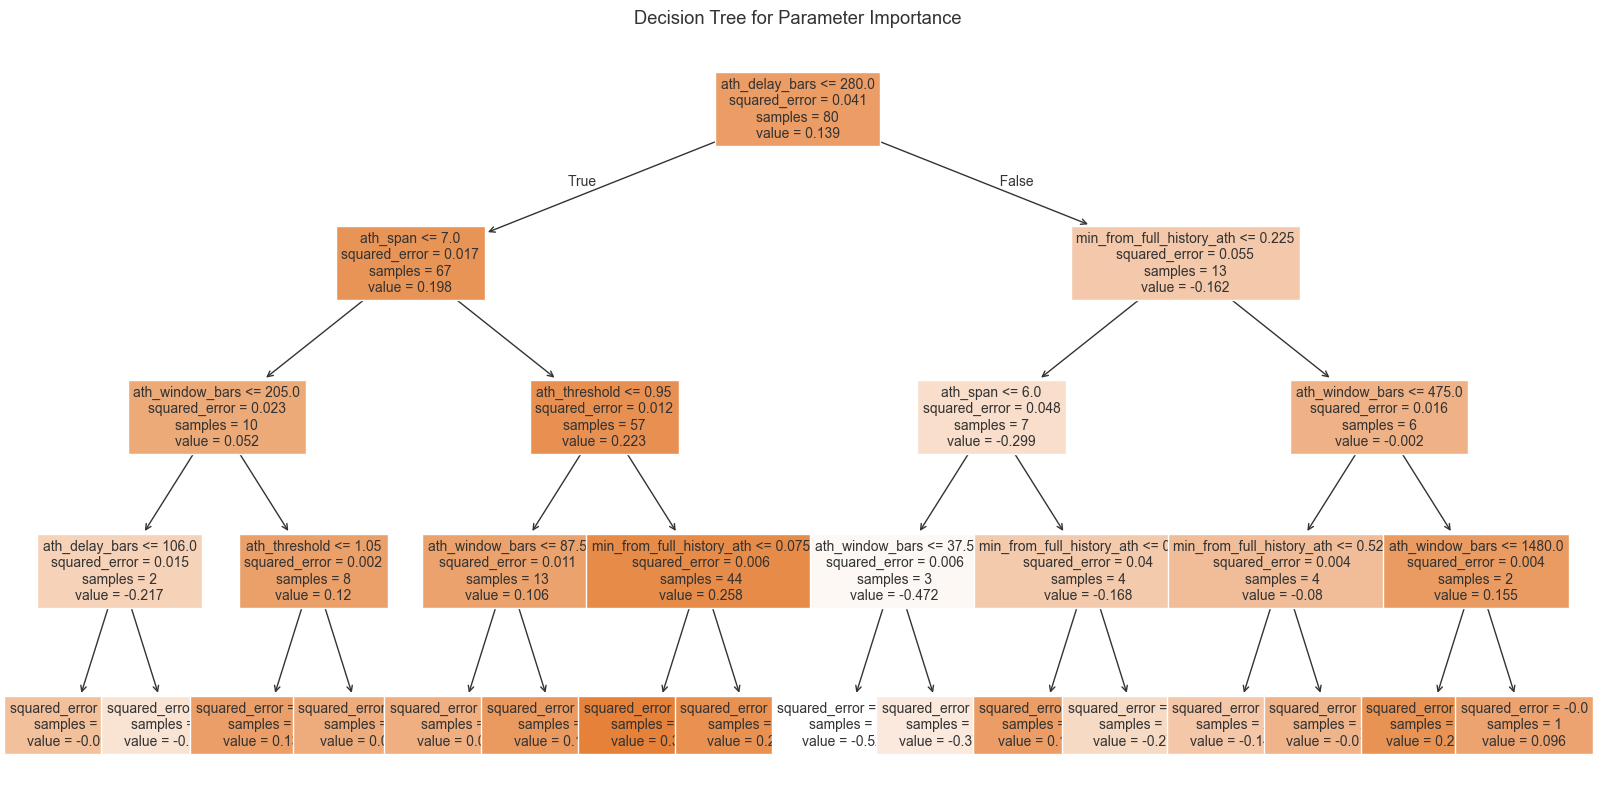

In [11]:
import matplotlib.pyplot as plt

from sklearn.calibration import LabelEncoder
from sklearn.tree import DecisionTreeRegressor, plot_tree

parameter_names = list(df.index.names)
parameter_df = df
parameter_df = parameter_df.reset_index()

analysis_metric = "CAGR"
print(f"Analysing {analysis_metric} for parameters: {parameter_names}")

# Prepare data
X = parameter_df[parameter_names]
y = parameter_df[analysis_metric]

# Convert categorical values if needed
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# Train a simple decision tree
tree = DecisionTreeRegressor(max_depth=4)
tree.fit(X, y)

# Plot
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X.columns, filled=True, fontsize=10)
plt.title('Decision Tree for Parameter Importance')
plt.show()

## Feature importance analysis

Use a regression model to determine which parameters have the strongest influence.



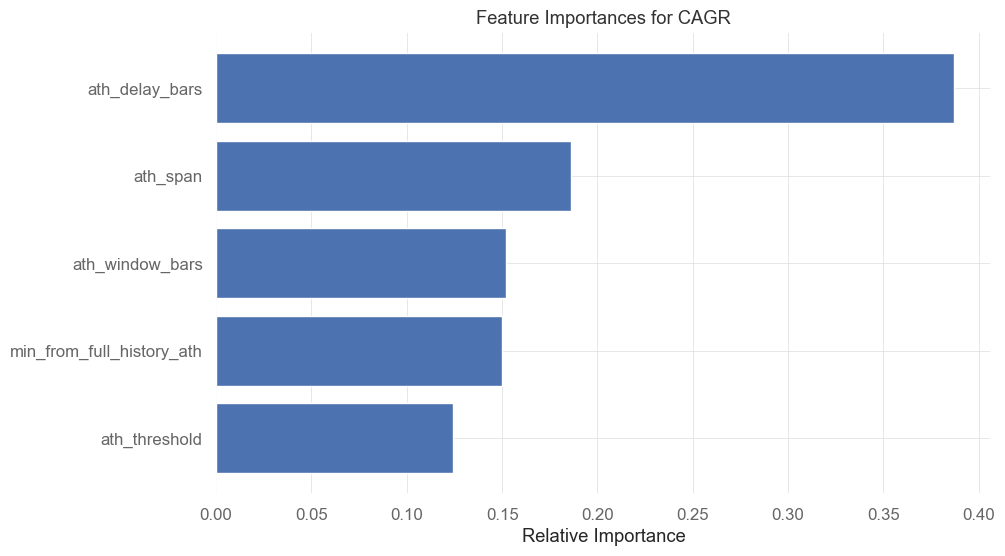

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
X = parameter_df[parameter_names]
y = parameter_df[analysis_metric]

# Convert categorical values to numeric if needed
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# Train a random forest model
model = RandomForestRegressor(n_estimators=100)
model.fit(X, y)

# Plot feature importances
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title(f'Feature Importances for {analysis_metric}')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Heatmaps for parameter pairs

/var/folders/8n/h2dzh5yx5470cc6c_12dwrjw0000gn/T/ipykernel_51527/2740836782.py:6: FutureWarning:

The provided callable <function mean at 0x1076da700> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.



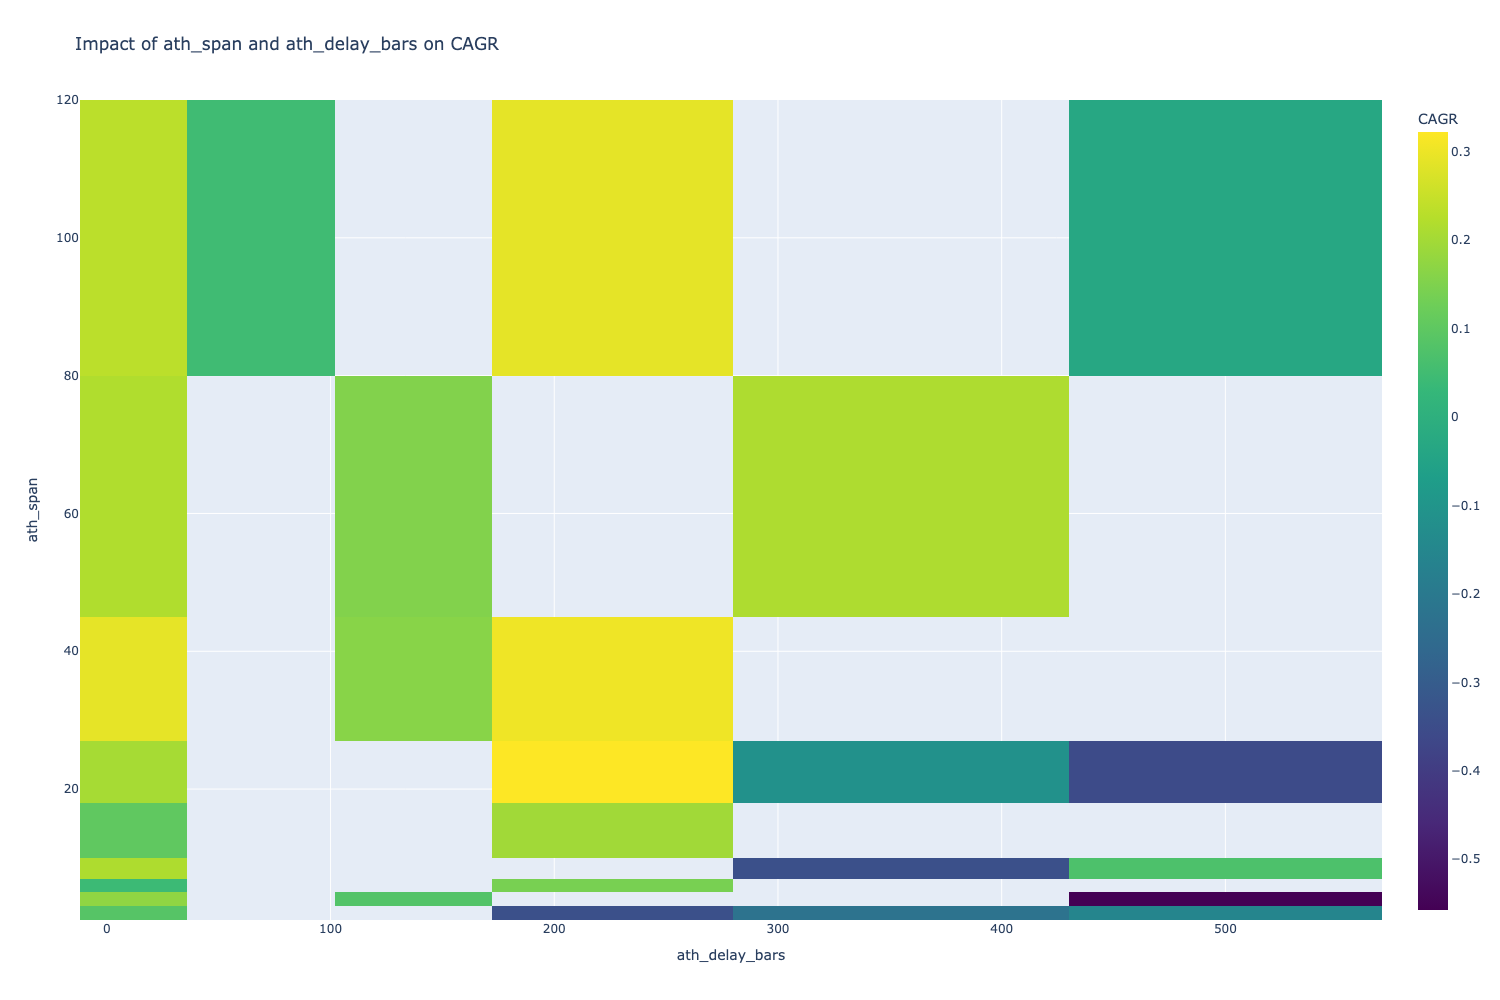

/var/folders/8n/h2dzh5yx5470cc6c_12dwrjw0000gn/T/ipykernel_51527/2740836782.py:6: FutureWarning:

The provided callable <function mean at 0x1076da700> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.



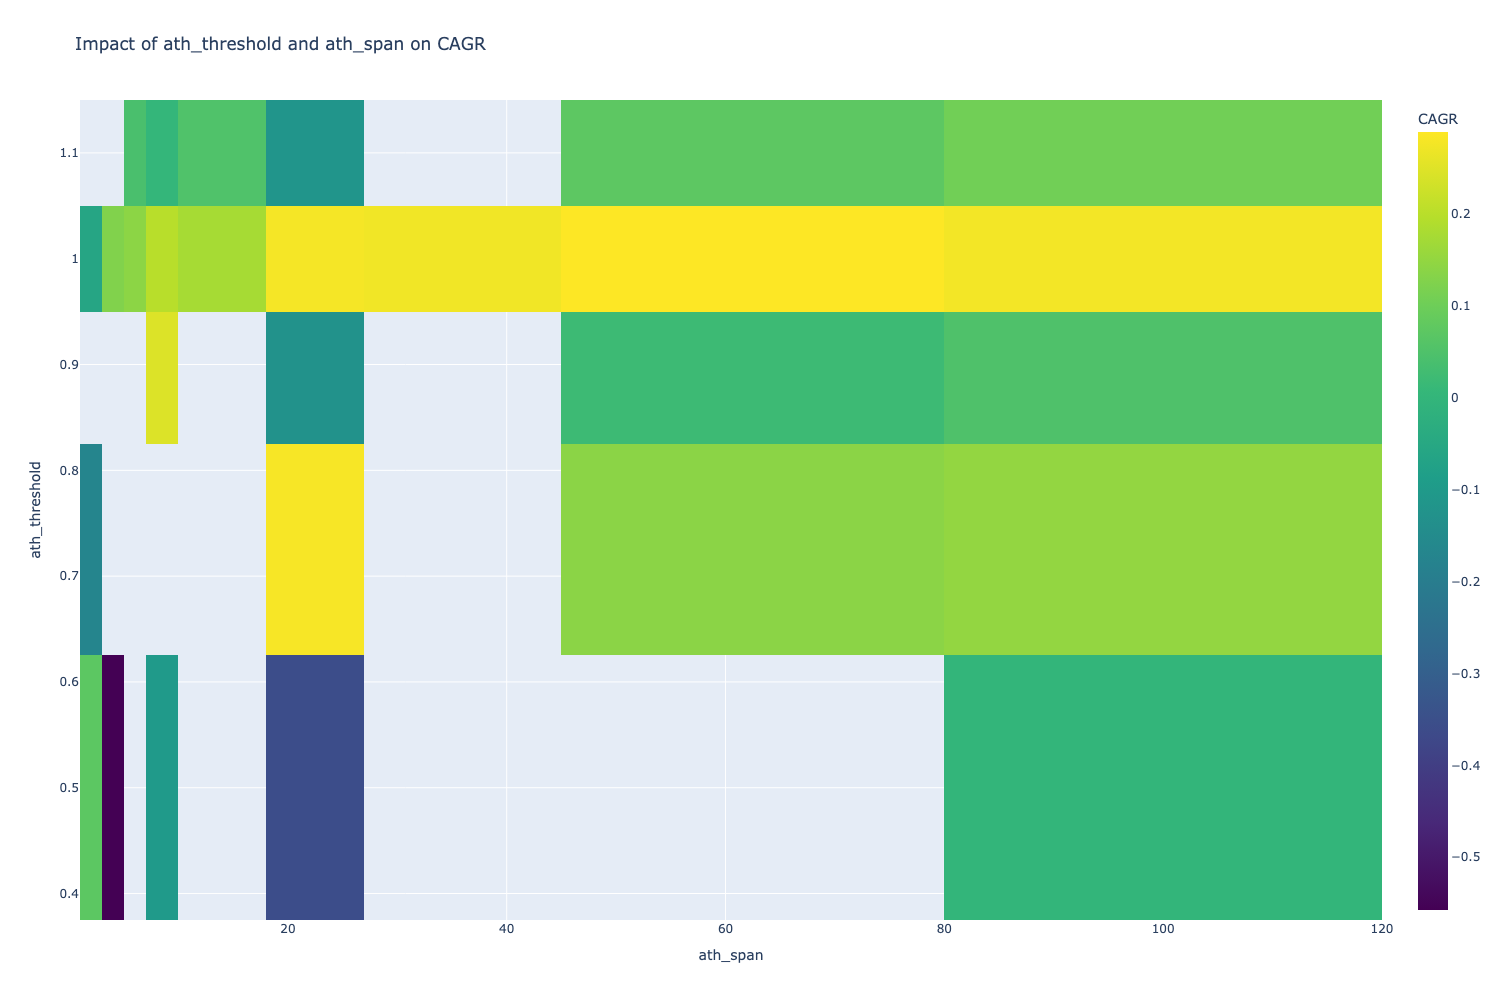

/var/folders/8n/h2dzh5yx5470cc6c_12dwrjw0000gn/T/ipykernel_51527/2740836782.py:6: FutureWarning:

The provided callable <function mean at 0x1076da700> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.



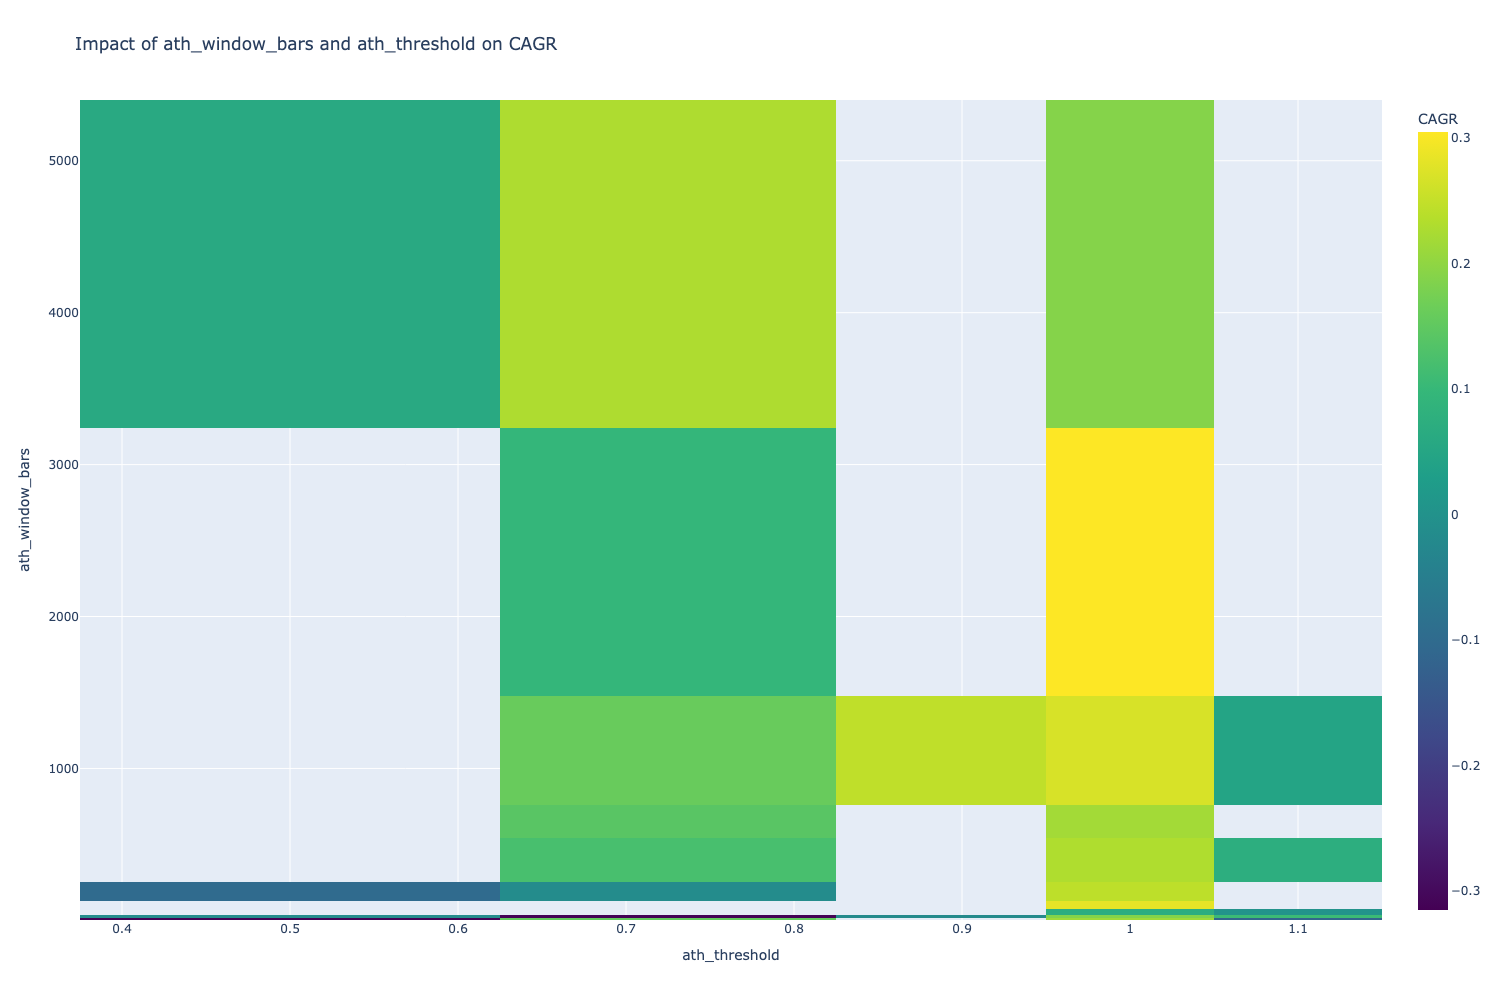

/var/folders/8n/h2dzh5yx5470cc6c_12dwrjw0000gn/T/ipykernel_51527/2740836782.py:6: FutureWarning:

The provided callable <function mean at 0x1076da700> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.



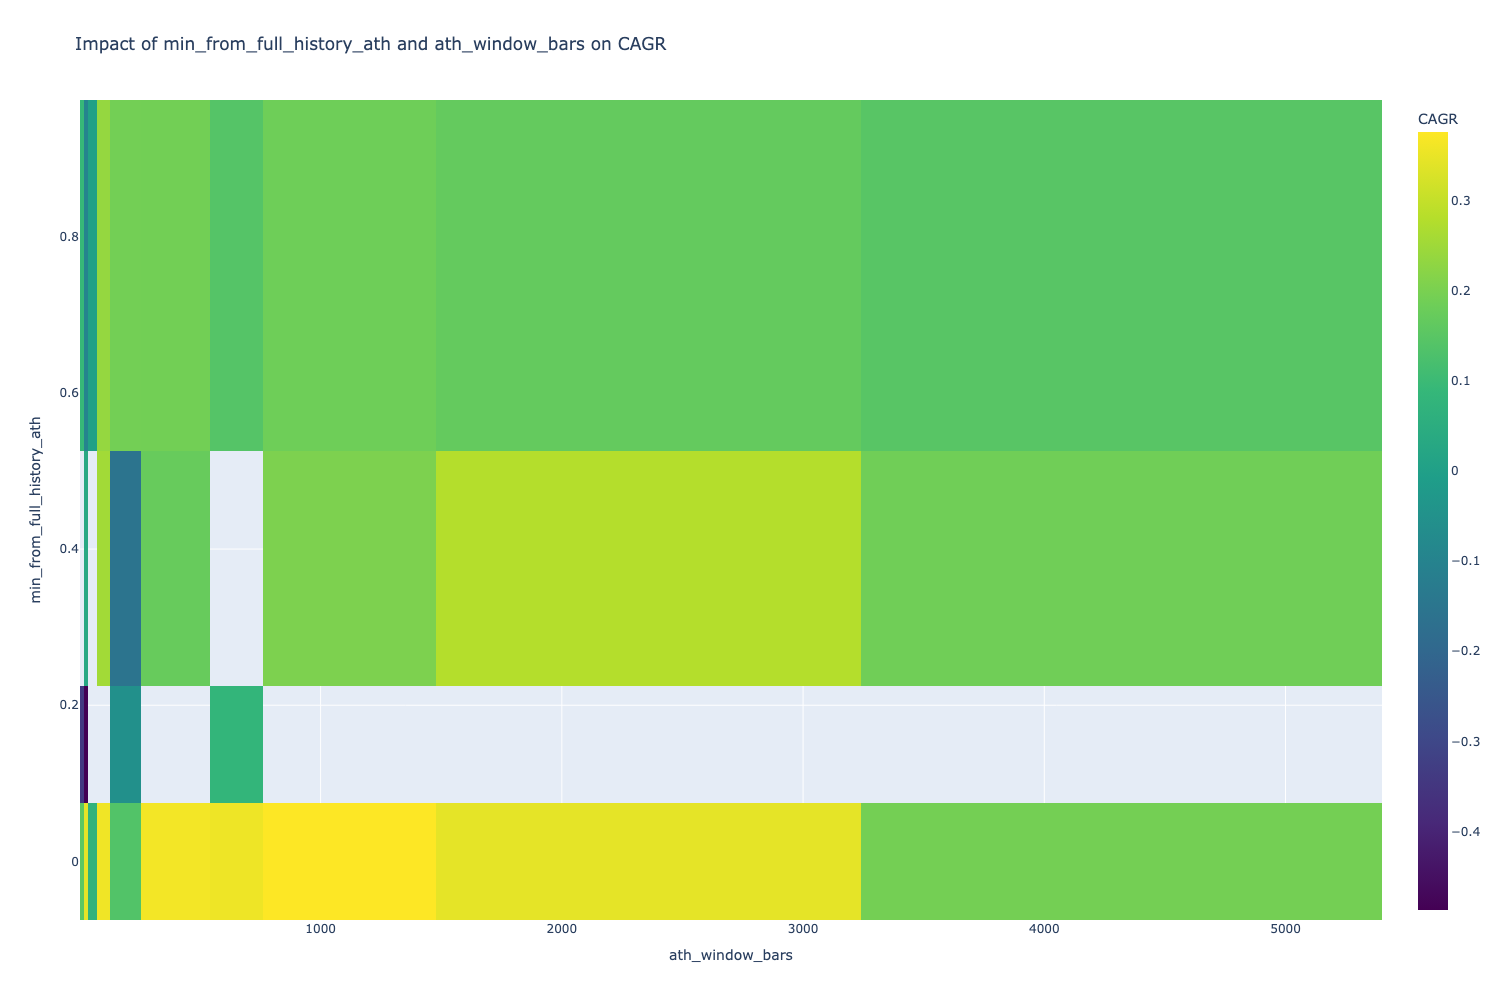

In [13]:
import plotly.graph_objects as go
import numpy as np

def create_heatmap(df, param1, param2, metric):
    # Create pivot table
    pivot = df.pivot_table(
        values=metric, 
        index=param1,
        columns=param2,
        aggfunc=np.mean
    )
    
    fig = go.Figure(data=go.Heatmap(
        z=pivot.values,
        x=pivot.columns,
        y=pivot.index,
        colorscale='Viridis',
        colorbar=dict(title=metric)
    ))
    
    fig.update_layout(
        title=f'Impact of {param1} and {param2} on {metric}',
        xaxis_title=param2,
        yaxis_title=param1
    )
    
    return fig

# Example parameter pairs to analyze
param_pairs = []
for i in range(1, len(parameter_names), 1):
    param_pairs.append((parameter_names[i], parameter_names[i-1]))

for param1, param2 in param_pairs:
    fig = create_heatmap(parameter_df, param1, param2, metric=analysis_metric)
    fig.show()

## Cluster analysis

cluster      CAGR                              Sharpe                Max DD  \
               mean       min       max count      mean   min   max      mean   
0       0  0.106113 -0.015958  0.159295     5  0.882000  0.13  1.25 -0.218000   
1       1  0.122736 -0.371799  0.381295    26  1.301923 -0.95  3.28 -0.255769   
2       2  0.174268  0.047077  0.281157    12  2.225000  0.42  3.45 -0.100000   
3       3  0.255991  0.020877  0.388824    28  2.614643  0.26  3.52 -0.101071   
4       4 -0.203212 -0.557404  0.137654     9 -0.401111 -1.48  0.81 -0.644444   

               
    min   max  
0 -0.52 -0.12  
1 -0.89 -0.05  
2 -0.32 -0.03  
3 -0.49 -0.03  
4 -0.92 -0.20

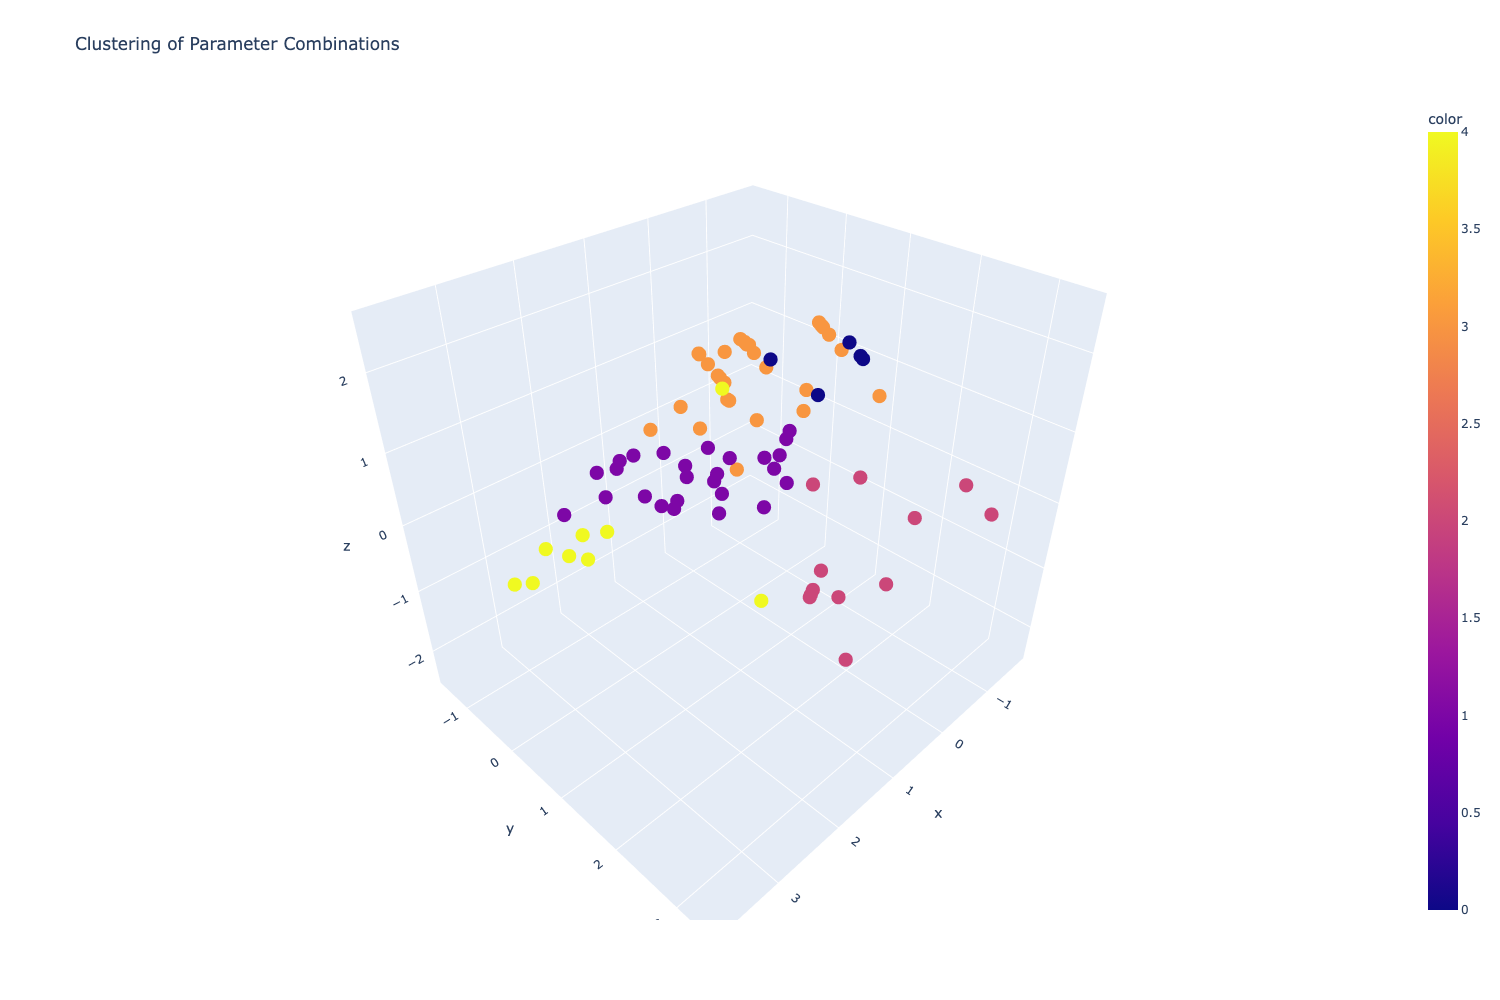

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px

# Select features for clustering
features = parameter_names
X = parameter_df[features]

# Convert categorical values to numeric
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-means clustering (determine optimal k separately)
kmeans = KMeans(n_clusters=5, random_state=42)
parameter_df['cluster'] = kmeans.fit_predict(X_scaled)

# Analyze performance by cluster
cluster_perf = parameter_df.groupby('cluster').agg({
    'CAGR': ['mean', 'min', 'max', 'count'],
    'Sharpe': ['mean', 'min', 'max'],
    'Max DD': ['mean', 'min', 'max']
}).reset_index()

display(cluster_perf)

# Visualize clusters in 3D space (using first 3 PCA components)
from sklearn.decomposition import PCA

try:
    pca = PCA(n_components=3)
    components = pca.fit_transform(X_scaled)

    fig = px.scatter_3d(
        x=components[:, 0],
        y=components[:, 1],
        z=components[:, 2],
        color=parameter_df['cluster'],
        hover_data={'Sharpe': parameter_df['Sharpe'], 'CAGR': parameter_df['CAGR']},
        title='Clustering of Parameter Combinations'
    )
    fig.show()
except ValueError as e:
    print(f"Error in PCA: {e}")
    print("PCA failed, possibly due to too few features or singular matrix.")
    # Handle the error as needed

## Parallel coordinates plot

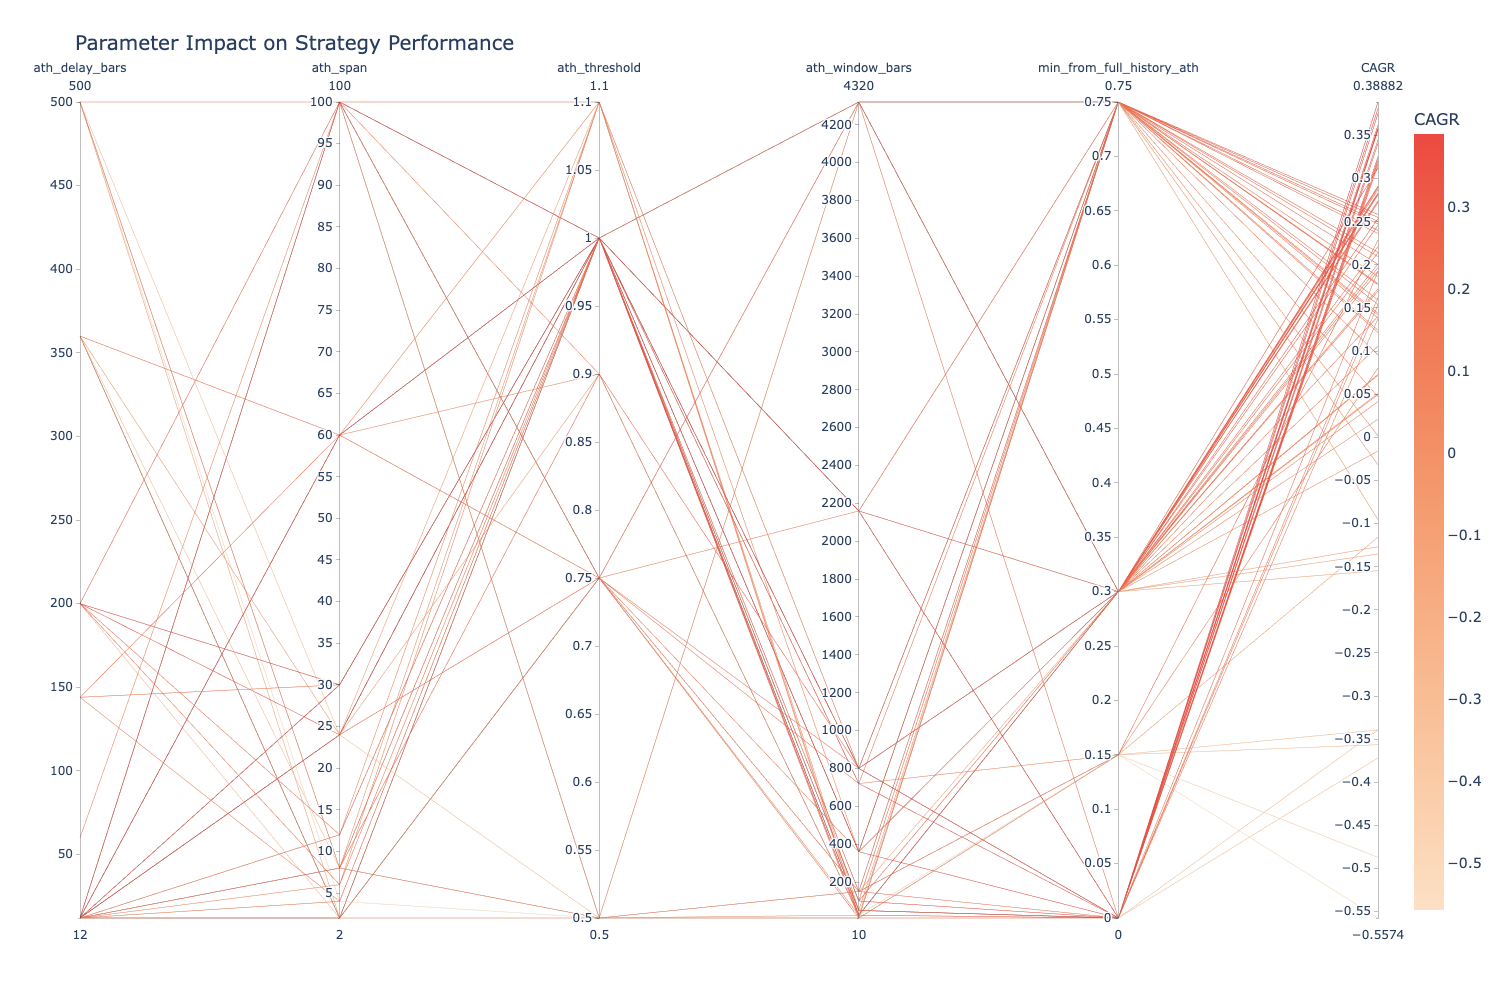

In [15]:
import plotly.express as px

# Extract top results (e.g., top 50)
top_results = parameter_df.head(50)

dimensions = parameter_names + [analysis_metric]

# Create parallel coordinates plot
fig = px.parallel_coordinates(
    parameter_df,
    dimensions=dimensions,
    color=analysis_metric,
    color_continuous_scale=px.colors.sequential.Peach,
    title='Parameter Impact on Strategy Performance'
)


# Increase font size for axis titles, tick labels, and title
fig.update_layout(
    font=dict(size=14),  # Base font size for the whole figure
    title=dict(
        text='Parameter Impact on Strategy Performance',
        font=dict(size=20)  # Title font size
    ),
    coloraxis_colorbar=dict(
        title=dict(
            text=analysis_metric,
            font=dict(size=16)
        ),
        tickfont=dict(size=14)
    )
)

# Parallel coordinates chart: Line width not supported
# https://github.com/plotly/plotly.js/issues/2573

fig.show()

# The best candidate equity curve

The best result found for <function optimise_sharpe at 0x3362a6660> was <GridSearchResult
  #55, ath_delay_bars=12, ath_span=100, ath_threshold=1.0, ath_window_bars=2160, min_from_full_history_ath=0.3
  CAGR: 27.00%, Sharpe: 3.52, Sortino: 12.44, Max drawdown:-3.00%
>


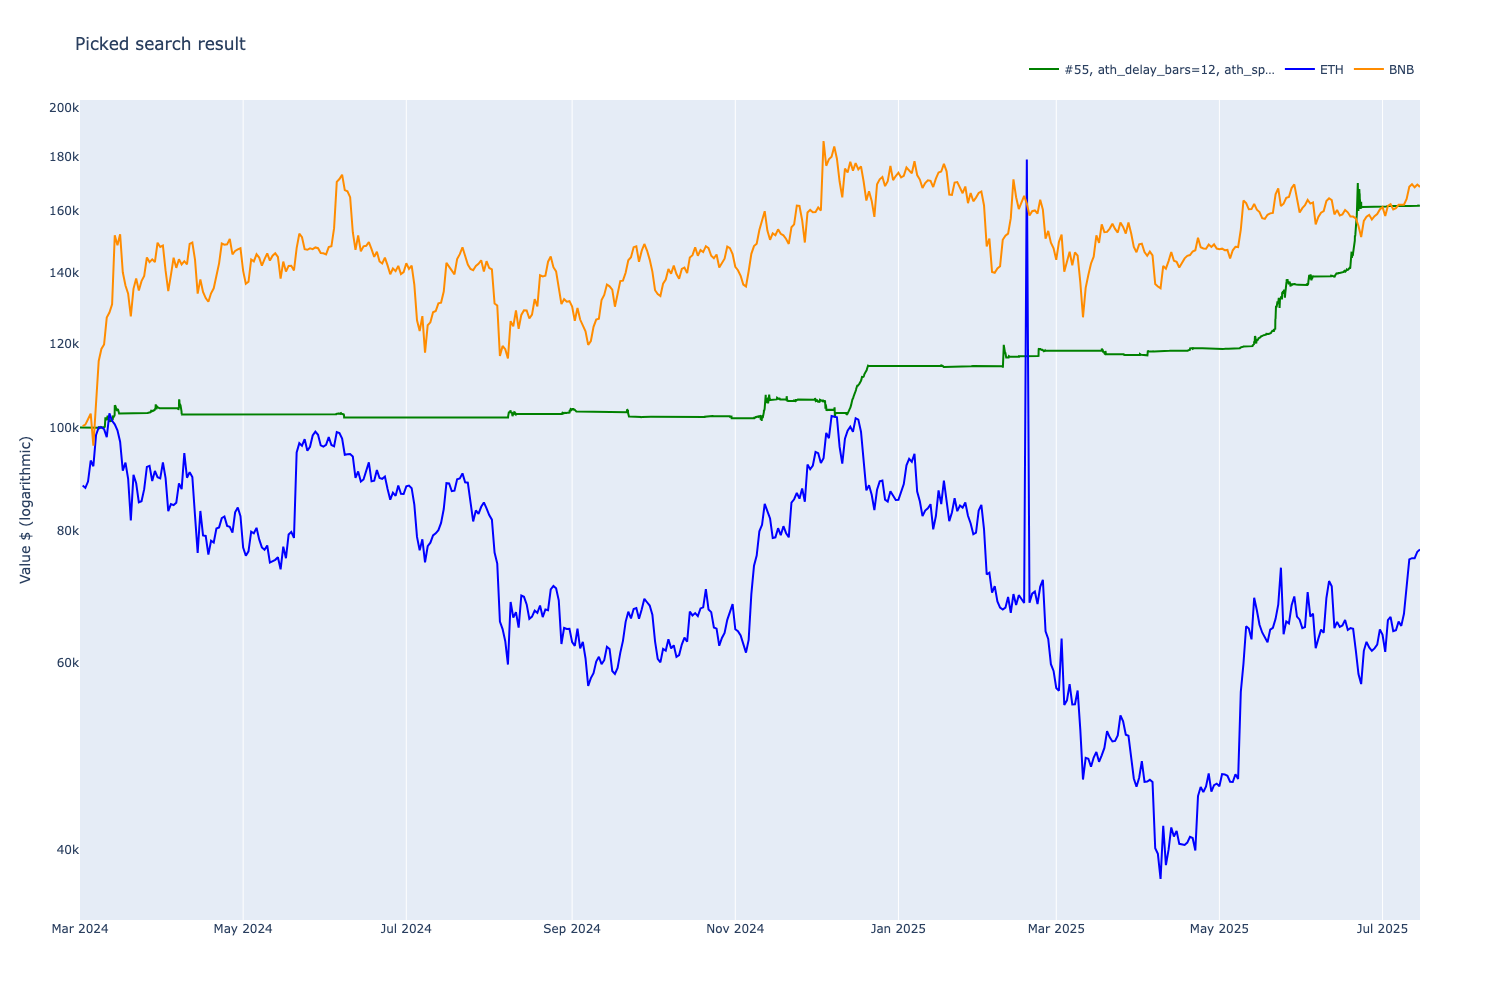

In [16]:
from tradeexecutor.visual.grid_search import visualise_single_grid_search_result_benchmark

# GridSearchResult instance that gave the best performance
best_pick = optimiser_result.results[0].result
state = best_pick.hydrate_state()

print(f"The best result found for {search_func} was {best_pick}")

fig = visualise_single_grid_search_result_benchmark(
    best_pick, 
    strategy_universe, 
    initial_cash=Parameters.initial_cash,
    log_y=True,
)
fig.show()

# Portfolio performance (best pick)

- Compare buy and hold against our best performance

In [17]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

returns = best_pick.returns

df = compare_strategy_backtest_to_multiple_assets(
    state=state,
    strategy_universe=strategy_universe,
    returns=returns,
    display=True,
    asset_count=3,
)
display(df)

Strategy                  ETH  \
Start Period                        2024-03-01           2024-03-01   
End Period                          2025-07-14           2025-07-14   
Risk-Free Rate                            0.0%                 0.0%   
Time in Market                           37.0%                99.0%   
Cumulative Return                       61.76%              -22.39%   
CAGR﹪                                   27.43%              -11.99%   
Sharpe                                    3.52                 0.49   
Prob. Sharpe Ratio                      100.0%               74.94%   
Smart Sharpe                              1.96                 0.27   
Sortino                                  12.44                 1.12   
Smart Sortino                             6.93                 0.62   
Sortino/√2                                 8.8                 0.79   
Smart Sortino/√2                           4.9                 0.44   
Omega                                     3.87                 3.87   
Max Drawdown                            -3.23%               -79.0%   
Longest DD Days                            227                  342   
Volatility (ann.)                       10.09%              164.76%   
Calmar                                     8.5                -0.15   
Skew                                      4.94                12.46   
Kurtosis                                 34.37               251.05   
Expected Daily                            0.1%               -0.05%   
Expected Monthly                         2.87%               -1.48%   
Expected Yearly                         27.18%              -11.91%   
Kelly Criterion                         44.33%               11.33%   
Risk of Ruin                              0.0%                 0.0%   
Daily Value-at-Risk                     -0.77%              -13.96%   
Expected Shortfall (cVaR)               -0.77%              -13.96%   
Max Consecutive Wins                        15                    8   
Max Consecutive Losses                       3                    9   
Gain/Pain Ratio                           2.87                 0.16   
Gain/Pain (1M)                            10.1                 1.45   
Payoff Ratio                               2.6                 1.33   
Profit Factor                             3.87                 1.16   
Common Sense Ratio                       24.04                 1.15   
CPC Index                                 6.02                 0.76   
Tail Ratio                                6.21                 0.99   
Outlier Win Ratio                         16.0                 2.24   
Outlier Loss Ratio                        3.61                  2.0   
MTD                                      0.23%               18.35%   
3M                                      36.98%               81.86%   
6M                                      41.54%               -9.79%   
YTD                                     41.54%               -10.6%   
1Y                                      58.28%               -4.57%   
3Y (ann.)                               27.43%              -11.99%   
5Y (ann.)                               27.43%              -11.99%   
10Y (ann.)                              27.43%              -11.99%   
All-time (ann.)                         27.43%              -11.99%   
Best Day                                 5.27%              161.63%   
Worst Day                               -1.21%              -61.76%   
Best Month                              18.44%               42.72%   
Worst Month                             -1.52%              -29.38%   
Best Year                               41.54%               -10.6%   
Worst Year                              14.28%              -13.19%   
Avg. Drawdown                            -0.8%              -41.91%   
Avg. Drawdown Days                          27                  163   
Recovery Factor                          15.12                

# Trade summary (best pick)

- Show statistics about the made trades

In [18]:
summary = best_pick.summary
display(summary.to_dataframe())

# Trading pair performance breakdown

- Show breakdown of different pairs on the best result

In [19]:
from tradeexecutor.analysis.multipair import analyse_multipair
from tradeexecutor.analysis.multipair import format_multipair_summary

multipair_summary = analyse_multipair(state)
display(format_multipair_summary(multipair_summary))

# Best positions

- Find positions that made most profit for the leading backtest

In [20]:
profit_by_position = [(p.get_realised_profit_usd(), p) for p in state.portfolio.get_all_positions()]
profit_by_position.sort(key=lambda t: t[0] or -999_999_999, reverse=True)

data = []

for profit, p in profit_by_position[0:5]:
    data.append({
        "Profit USD": profit,
        "Pair": p.pair.get_ticker(),
        "Position id": p.position_id,
        "Opened": p.opened_at,
        "Closed": p.closed_at,
        "Duration": p.closed_at - p.opened_at if p.closed_at else "(still open)",
        "Open price": p.get_opening_price(),
        "Close price": p.get_closing_price(),
        "Trades": p.get_trade_count(),
        "Price gain %": (p.get_closing_price() - p.get_opening_price()) / p.get_opening_price() * 100,
        "Weight at open %": p.get_capital_tied_at_open_pct() * 100,
    })

df = pd.DataFrame(data)
display(df)

Profit USD        Pair  Position id              Opened  \
0  19850.948390   FIST-USDT           72 2025-06-18 16:00:00   
1  12055.353260      B-WBNB           59 2025-05-21 01:00:00   
2  11084.550490  STP-X-USDT           40 2024-12-12 14:00:00   
3   4270.215627    VPS-USDT           57 2025-05-13 01:00:00   
4   4270.178055   DOGE-WBNB           28 2024-11-10 20:00:00   

               Closed         Duration  Open price  Close price  Trades  \
0 2025-06-23 02:00:00  4 days 10:00:00    0.180780     0.407386      58   
1 2025-05-28 07:00:00  7 days 06:00:00    0.038897     0.389368      46   
2 2024-12-20 16:00:00  8 days 02:00:00    0.055263     0.169301      19   
3 2025-05-28 03:00:00 15 days 02:00:00   25.193951   113.060531      11   
4 2024-11-13 22:00:00  3 days 02:00:00    0.271654     0.381723      24   

   Price gain %  Weight at open %  
0    125.348460          4.933122  
1    901.028983          1.583482  
2    206.355295          7.503691  
3    348.760619          1.613840  
4     40.517937          9.664483

# Rolling sharpe

- The rolling sharpe ratio of the best pick

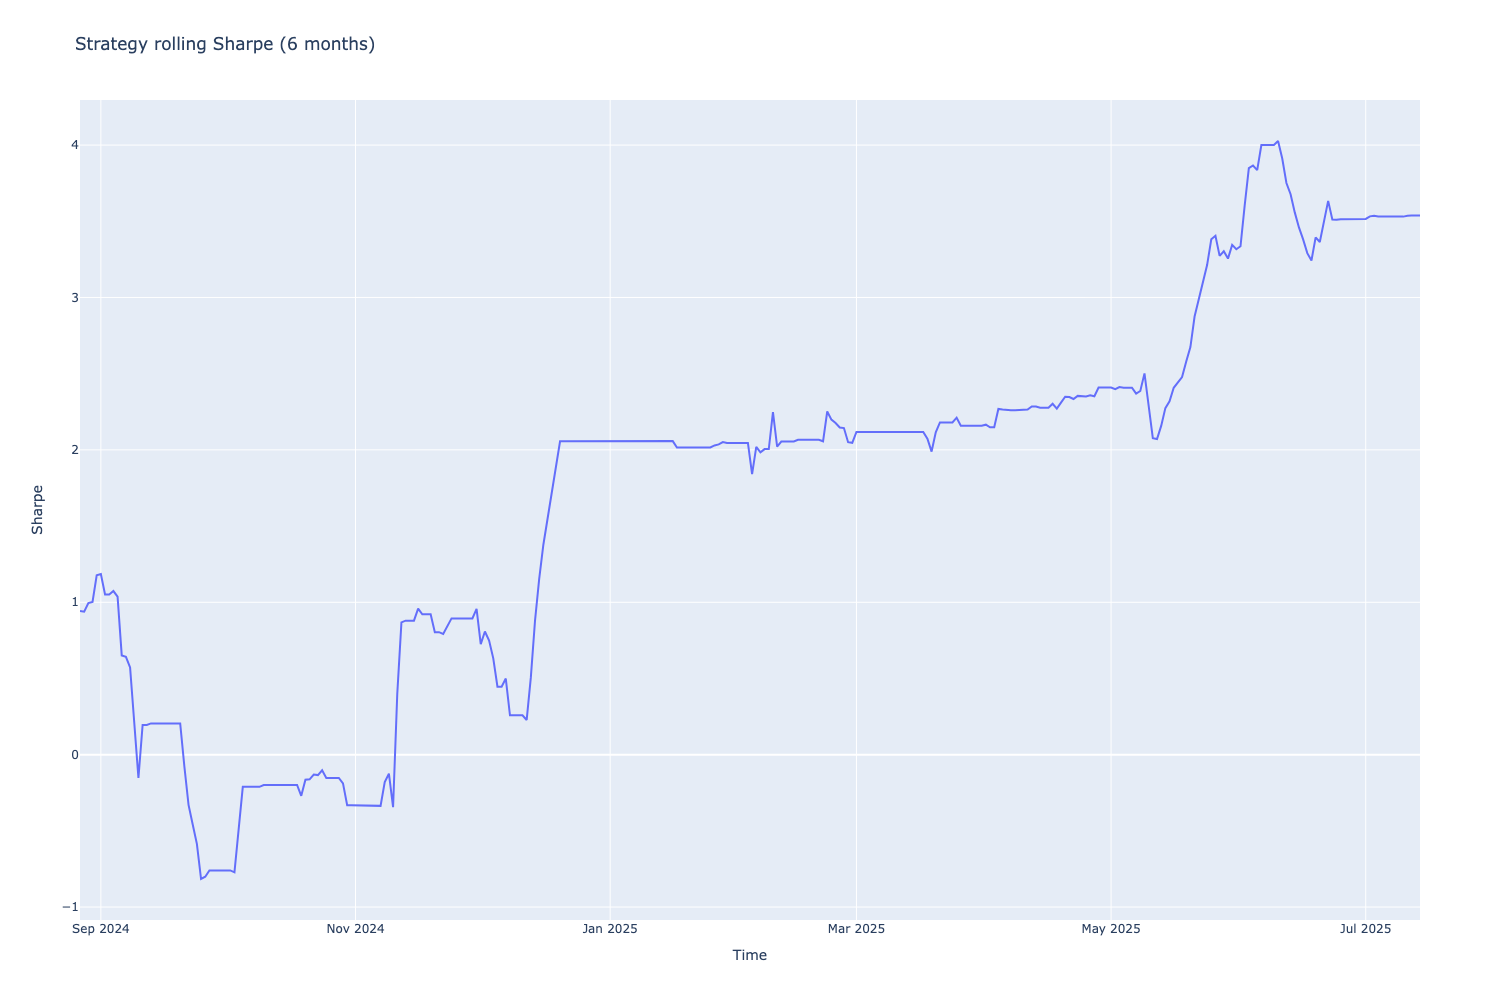

In [21]:
import plotly.express as px

from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import calculate_rolling_sharpe

rolling_sharpe = calculate_rolling_sharpe(
    returns,
    freq="D",
    periods=180,
)

fig = px.line(rolling_sharpe, title='Strategy rolling Sharpe (6 months)')
fig.update_layout(showlegend=False)
fig.update_yaxes(title="Sharpe")
fig.update_xaxes(title="Time")
fig.show()

# Data diagnosics

- Some example code to track down issues with data


In [22]:
# data = [{"Timestamp": s.calculated_at, "Equity": s.net_asset_value} for s in state.stats.portfolio]
# df = pd.DataFrame(data)
# df = df.set_index("Timestamp")

# with pd.option_context('display.min_rows', 50, "display.max_rows", 50):
#     display(df)

In [23]:
# for t in state.portfolio.get_all_trades():
#     if t.executed_at.date() == datetime.date(2023, 12, 29):
#         print(t, t.pair, t.get_value())

In [24]:
# import plotly.graph_objects as go

# pair_desc = (ChainId.ethereum, "uniswap-v3", "WBTC", "USDC", 0.0005)
# pair = strategy_universe.get_pair_by_human_description(pair_desc)
# df = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)


# fig = go.Figure(data=go.Ohlc(x=df.timestamp,
#                     open=df.open,
#                     high=df.high,
#                     low=df.low,
#                     close=df.close))
# fig.show()

# with pd.option_context('display.min_rows', 5000, "display.max_rows", 5000, 'display.float_format', lambda x: f'{x:.6f}'):
#     display(df)